# 🔍 Root Cause Analysis using Knowledge Graphs & LLM

## Complete 4-Phase Workflow:
1. **Data Preprocessing** - Load, clean, and merge event and performance data
2. **Knowledge Graph Construction** - Build entity-relationship graph
3. **Causal Analysis & Inference** - Detect root causes using correlations and graph algorithms
4. **LLM Integration** - Query the knowledge graph using natural language

---

## Install Required Dependencies

Install all necessary packages for data analysis, graph processing, visualization, and LLM integration.

In [1]:
# Install required packages
!pip install pandas numpy networkx matplotlib seaborn pyvis scipy scikit-learn -q
!pip install transformers torch sentence-transformers -q
!pip install plotly kaleido -q

print("All dependencies installed successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 89.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 5.4 MB/s eta 0:00:00
All dependencies installed successfully!


## Import Libraries

In [2]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Graph libraries
import networkx as nx
from pyvis.network import Network

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

# Statistical analysis
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# LLM Integration
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM
import torch

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("All libraries imported successfully!")
print(f"PyTorch CUDA available: {torch.cuda.is_available()}")

All libraries imported successfully!
PyTorch CUDA available: True


---
# PHASE 1: Data Understanding & Preprocessing

Load both CSV files, explore the data structure, and perform comprehensive cleaning and feature engineering.

## 1.1 Load Data Files

**Note:** Upload `event.csv` and `perf.csv` to your Colab session first.

In [3]:
# Load the CSV files
# If files are in Google Drive, mount and update paths accordingly
try:
    events_df = pd.read_csv('/content/event .csv')
    perf_df = pd.read_csv('/content/perf.csv')
    print("Data loaded successfully!")
    print(f"\n Events data shape: {events_df.shape}")
    print(f"Performance data shape: {perf_df.shape}")
except FileNotFoundError:
    print("Files not found. Please upload 'event.csv' and 'perf.csv' to Colab.")
    print("Run the following to upload:")
    print("from google.colab import files")
    print("uploaded = files.upload()")

Data loaded successfully!

 Events data shape: (733, 21)
Performance data shape: (1692, 18)


## 1.2 Initial Data Exploration

In [4]:
# Display first few rows of events data
print("=" * 80)
print("EVENT DATA - First 5 rows")
print("=" * 80)
display(events_df.head())

print("\n" + "=" * 80)
print("EVENT DATA - Info")
print("=" * 80)
print(events_df.info())

print("\n" + "=" * 80)
print("EVENT DATA - Summary Statistics")
print("=" * 80)
display(events_df.describe())

EVENT DATA - First 5 rows


,TenantId,SourceSystem,TimeGenerated [UTC],Source,EventLog,Computer,EventLevel,EventLevelName,ParameterXml,EventData,...,RenderedDescription,AzureDeploymentID,Role,EventCategory,UserName,Message,MG,ManagementGroupName,Type,_ResourceId
0,d558e95b-08c4-4c42-b17a-dd6de6332e26,OpsManager,2024-06-26 16:50:35.925,Microsoft-Windows-Kernel-General,System,forensicsacl2,4,Information,<Param>10</Param><Param>0</Param><Param>19041<...,"<DataItem Type=""System.XmlData"" time=""2024-06-...",...,The operating system started at system time ‎2...,NaN,NaN,1,S-1-5-18,NaN,00000000-0000-0000-0000-000000000001,AOI-d558e95b-08c4-4c42-b17a-dd6de6332e26,Event,/subscriptions/da2ead26-5eba-476e-90f5-13d2028...
1,d558e95b-08c4-4c42-b17a-dd6de6332e26,OpsManager,2024-06-26 16:50:35.925,Microsoft-Windows-Kernel-Boot,System,forensicsacl2,4,Information,<Param>0</Param><Param>0</Param><Param>0</Param>,"<DataItem Type=""System.XmlData"" time=""2024-06-...",...,Virtualization-based security (policies: 0) is...,NaN,NaN,62,S-1-5-18,NaN,00000000-0000-0000-0000-000000000001,AOI-d558e95b-08c4-4c42-b17a-dd6de6332e26,Event,/subscriptions/da2ead26-5eba-476e-90f5-13d2028...
2,d558e95b-08c4-4c42-b17a-dd6de6332e26,OpsManager,2024-06-26 16:50:35.925,Microsoft-Windows-Kernel-Boot,System,forensicsacl2,4,Information,<Param>true</Param><Param>true</Param><Param>7...,"<DataItem Type=""System.XmlData"" time=""2024-06-...",...,The last shutdown's success status was true. T...,NaN,NaN,31,S-1-5-18,NaN,00000000-0000-0000-0000-000000000001,AOI-d558e95b-08c4-4c42-b17a-dd6de6332e26,Event,/subscriptions/da2ead26-5eba-476e-90f5-13d2028...
3,d558e95b-08c4-4c42-b17a-dd6de6332e26,OpsManager,2024-06-26 16:50:35.925,Microsoft-Windows-Kernel-Boot,System,forensicsacl2,4,Information,<Param>2047</Param><Param>0</Param>,"<DataItem Type=""System.XmlData"" time=""2024-06-...",...,EFI time zone bias: 2047. Daylight flags: 0,NaN,NaN,101,S-1-5-18,NaN,00000000-0000-0000-0000-000000000001,AOI-d558e95b-08c4-4c42-b17a-dd6de6332e26,Event,/subscriptions/da2ead26-5eba-476e-90f5-13d2028...
4,d558e95b-08c4-4c42-b17a-dd6de6332e26,OpsManager,2024-06-26 16:50:35.925,Microsoft-Windows-Kernel-Boot,System,forensicsacl2,4,Information,<Param>1</Param>,"<DataItem Type=""System.XmlData"" time=""2024-06-...",...,The boot menu policy was 0x1.,NaN,NaN,32,S-1-5-18,NaN,00000000-0000-0000-0000-000000000001,AOI-d558e95b-08c4-4c42-b17a-dd6de6332e26,Event,/subscriptions/da2ead26-5eba-476e-90f5-13d2028...



EVENT DATA - Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 733 entries, 0 to 732
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   TenantId             733 non-null    object 
 1   SourceSystem         733 non-null    object 
 2   TimeGenerated [UTC]  733 non-null    object 
 3   Source               733 non-null    object 
 4   EventLog             733 non-null    object 
 5   Computer             733 non-null    object 
 6   EventLevel           733 non-null    int64  
 7   EventLevelName       733 non-null    object 
 8   ParameterXml         712 non-null    object 
 9   EventData            733 non-null    object 
 10  EventID              733 non-null    int64  
 11  RenderedDescription  733 non-null    object 
 12  AzureDeploymentID    0 non-null      float64
 13  Role                 0 non-null      float64
 14  EventCategory        733 non-null    int64  
 15  UserName             

,EventLevel,EventID,AzureDeploymentID,Role,EventCategory,Message
count,733.000000,733.000000,0.0,0.0,733.000000,0.0
mean,1.461119,4086.477490,NaN,NaN,8195.437926,NaN
std,1.914191,4357.272121,NaN,NaN,6382.912824,NaN
min,0.000000,0.000000,NaN,NaN,0.000000,NaN
25%,0.000000,102.000000,NaN,NaN,0.000000,NaN
50%,0.000000,4672.000000,NaN,NaN,12544.000000,NaN
75%,4.000000,5379.000000,NaN,NaN,13824.000000,NaN
max,4.000000,51046.000000,NaN,NaN,13826.000000,NaN


In [5]:
# Display first few rows of performance data
print("=" * 80)
print("PERFORMANCE DATA - First 5 rows")
print("=" * 80)
display(perf_df.head())

print("\n" + "=" * 80)
print("PERFORMANCE DATA - Info")
print("=" * 80)
print(perf_df.info())

print("\n" + "=" * 80)
print("PERFORMANCE DATA - Summary Statistics")
print("=" * 80)
display(perf_df.describe())

PERFORMANCE DATA - First 5 rows


,TenantId,Computer,ObjectName,CounterName,InstanceName,CounterValue,TimeGenerated [UTC],SourceSystem,CounterPath,MG,Min,Max,SampleCount,BucketStartTime [UTC],BucketEndTime [UTC],StandardDeviation,Type,_ResourceId
0,d558e95b-08c4-4c42-b17a-dd6de6332e26,forensicsacl2,Process,Thread Count,_Total,1.179000e+03,"6/26/2024, 4:54:17.892 PM",OpsManager,\\forensicsacl2\Process(_Total)\Thread Count,00000000-0000-0000-0000-000000000001,NaN,NaN,NaN,NaN,NaN,NaN,Perf,/subscriptions/da2ead26-5eba-476e-90f5-13d2028...
1,d558e95b-08c4-4c42-b17a-dd6de6332e26,forensicsacl2,LogicalDisk,% Free Space,_Total,8.101061e+01,"6/26/2024, 4:54:17.892 PM",OpsManager,\\forensicsacl2\LogicalDisk(_Total)\% Free Space,00000000-0000-0000-0000-000000000001,NaN,NaN,NaN,NaN,NaN,NaN,Perf,/subscriptions/da2ead26-5eba-476e-90f5-13d2028...
2,d558e95b-08c4-4c42-b17a-dd6de6332e26,forensicsacl2,Process,Working Set - Private,_Total,7.477740e+08,"6/26/2024, 4:54:17.892 PM",OpsManager,\\forensicsacl2\Process(_Total)\Working Set - ...,00000000-0000-0000-0000-000000000001,NaN,NaN,NaN,NaN,NaN,NaN,Perf,/subscriptions/da2ead26-5eba-476e-90f5-13d2028...
3,d558e95b-08c4-4c42-b17a-dd6de6332e26,forensicsacl2,Processor Information,Processor Frequency,_Total,2.295000e+03,"6/26/2024, 4:54:17.892 PM",OpsManager,\\forensicsacl2\Processor Information(_Total)\...,00000000-0000-0000-0000-000000000001,NaN,NaN,NaN,NaN,NaN,NaN,Perf,/subscriptions/da2ead26-5eba-476e-90f5-13d2028...
4,d558e95b-08c4-4c42-b17a-dd6de6332e26,forensicsacl2,Network Interface,Packets Received Errors,Microsoft Hyper-V Network Adapter,0.000000e+00,"6/26/2024, 4:54:17.892 PM",OpsManager,\\forensicsacl2\Network Interface(Microsoft Hy...,00000000-0000-0000-0000-000000000001,NaN,NaN,NaN,NaN,NaN,NaN,Perf,/subscriptions/da2ead26-5eba-476e-90f5-13d2028...



PERFORMANCE DATA - Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1692 entries, 0 to 1691
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   TenantId               1692 non-null   object 
 1   Computer               1692 non-null   object 
 2   ObjectName             1692 non-null   object 
 3   CounterName            1692 non-null   object 
 4   InstanceName           1242 non-null   object 
 5   CounterValue           1692 non-null   float64
 6   TimeGenerated [UTC]    1692 non-null   object 
 7   SourceSystem           1692 non-null   object 
 8   CounterPath            1692 non-null   object 
 9   MG                     1692 non-null   object 
 10  Min                    0 non-null      float64
 11  Max                    0 non-null      float64
 12  SampleCount            0 non-null      float64
 13  BucketStartTime [UTC]  0 non-null      float64
 14  BucketEndTime [UTC]    0 non-nu

,CounterValue,Min,Max,SampleCount,BucketStartTime [UTC],BucketEndTime [UTC],StandardDeviation
count,1.692000e+03,0.0,0.0,0.0,0.0,0.0,0.0
mean,1.951235e+08,NaN,NaN,NaN,NaN,NaN,NaN
std,6.415785e+08,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN
25%,3.459847e+00,NaN,NaN,NaN,NaN,NaN,NaN
50%,1.595000e+02,NaN,NaN,NaN,NaN,NaN,NaN
75%,1.080210e+05,NaN,NaN,NaN,NaN,NaN,NaN
max,4.495245e+09,NaN,NaN,NaN,NaN,NaN,NaN


## 1.3 Data Cleaning & Preprocessing

In [6]:
# Function to clean and preprocess events data
def clean_events_data(df):
    """
    Clean and preprocess events data:
    - Handle missing values
    - Normalize timestamps
    - Extract key features
    - Encode categories
    """
    df_clean = df.copy()

    # 1. Convert timestamp to datetime
    df_clean['TimeGenerated'] = pd.to_datetime(df_clean['TimeGenerated [UTC]'], errors='coerce')

    # 2. Handle missing values in key columns
    df_clean['EventLevelName'].fillna('Unknown', inplace=True)
    df_clean['RenderedDescription'].fillna('No description', inplace=True)
    df_clean['Computer'].fillna('Unknown', inplace=True)

    # 3. Remove duplicates
    df_clean.drop_duplicates(subset=['TimeGenerated', 'EventID', 'Computer'], keep='first', inplace=True)

    # 4. Extract severity level (numeric encoding)
    severity_map = {'Critical': 5, 'Error': 4, 'Warning': 3, 'Information': 2, 'Verbose': 1, 'Unknown': 0}
    df_clean['Severity'] = df_clean['EventLevelName'].map(severity_map)

    # 5. Create event category from Source
    df_clean['EventCategory'] = df_clean['Source'].str.split('-').str[-1]

    # 6. Sort by timestamp
    df_clean.sort_values('TimeGenerated', inplace=True)
    df_clean.reset_index(drop=True, inplace=True)

    return df_clean

# Apply cleaning
events_clean = clean_events_data(events_df)
print("Events data cleaned!")
print(f"Original shape: {events_df.shape} → Cleaned shape: {events_clean.shape}")
print(f"Removed {len(events_df) - len(events_clean)} duplicate rows")

Events data cleaned!
Original shape: (733, 21) → Cleaned shape: (658, 23)
Removed 75 duplicate rows


In [7]:
# Function to clean and preprocess performance data
def clean_perf_data(df):
    """
    Clean and preprocess performance data:
    - Handle missing values
    - Normalize timestamps
    - Create metric identifiers
    """
    df_clean = df.copy()

    # 1. Convert timestamp to datetime
    df_clean['TimeGenerated'] = pd.to_datetime(df_clean['TimeGenerated [UTC]'], errors='coerce')

    # 2. Handle missing values
    df_clean['InstanceName'].fillna('_Total', inplace=True)
    df_clean['CounterValue'] = pd.to_numeric(df_clean['CounterValue'], errors='coerce')
    df_clean.dropna(subset=['CounterValue'], inplace=True)

    # 3. Create composite metric name
    df_clean['MetricName'] = df_clean['ObjectName'] + '_' + df_clean['CounterName'].str.replace(' ', '_')

    # 4. Remove duplicates
    df_clean.drop_duplicates(subset=['TimeGenerated', 'MetricName', 'Computer'], keep='first', inplace=True)

    # 5. Sort by timestamp
    df_clean.sort_values('TimeGenerated', inplace=True)
    df_clean.reset_index(drop=True, inplace=True)

    return df_clean

# Apply cleaning
perf_clean = clean_perf_data(perf_df)
print("Performance data cleaned!")
print(f"Original shape: {perf_df.shape} → Cleaned shape: {perf_clean.shape}")
print(f"Removed {len(perf_df) - len(perf_clean)} rows with missing/invalid values")

Performance data cleaned!
Original shape: (1692, 18) → Cleaned shape: (1692, 20)
Removed 0 rows with missing/invalid values


## 1.4 Feature Engineering

In [8]:
# Feature engineering for events data
def engineer_event_features(df):
    """
    Create advanced features from events data:
    - Event frequency
    - Time between events
    - Event bursts
    """
    df_feat = df.copy()

    # 1. Calculate time difference between consecutive events
    df_feat['TimeDelta'] = df_feat['TimeGenerated'].diff().dt.total_seconds()

    # 2. Event frequency per minute
    df_feat['EventsPerMinute'] = df_feat.groupby(df_feat['TimeGenerated'].dt.floor('1min'))['EventID'].transform('count')

    # 3. Rolling event count (last 5 events)
    df_feat['RollingEventCount'] = df_feat['EventID'].rolling(window=5, min_periods=1).count()

    # 4. Identify event bursts (more than 10 events per minute)
    df_feat['EventBurst'] = (df_feat['EventsPerMinute'] > 10).astype(int)

    # 5. Mean time between events by EventID
    df_feat['MeanTimeBetweenEvents'] = df_feat.groupby('EventID')['TimeDelta'].transform('mean')

    return df_feat

events_featured = engineer_event_features(events_clean)
print("Event features engineered!")
print(f"New columns added: {set(events_featured.columns) - set(events_clean.columns)}")

Event features engineered!
New columns added: {'EventsPerMinute', 'MeanTimeBetweenEvents', 'TimeDelta', 'EventBurst', 'RollingEventCount'}


In [9]:
# Feature engineering for performance data
def engineer_perf_features(df):
    """
    Create advanced features from performance data:
    - Rolling averages
    - Deviations from baseline
    - Threshold alerts
    """
    df_feat = df.copy()

    # Create pivot table for easier feature engineering
    pivot_df = df_feat.pivot_table(
        index=['TimeGenerated', 'Computer'],
        columns='MetricName',
        values='CounterValue',
        aggfunc='mean'
    ).reset_index()

    # Calculate rolling statistics for key metrics
    for col in pivot_df.columns[2:]:  # Skip TimeGenerated and Computer
        if pivot_df[col].dtype in ['float64', 'int64']:
            # Rolling mean (5 periods)
            pivot_df[f'{col}_RollingMean'] = pivot_df[col].rolling(window=5, min_periods=1).mean()

            # Deviation from mean
            pivot_df[f'{col}_Deviation'] = pivot_df[col] - pivot_df[col].mean()

            # Z-score for anomaly detection
            pivot_df[f'{col}_ZScore'] = (pivot_df[col] - pivot_df[col].mean()) / (pivot_df[col].std() + 1e-10)

    return pivot_df

perf_featured = engineer_perf_features(perf_clean)
print("Performance features engineered!")
print(f"Total features created: {len(perf_featured.columns)}")
print(f"Sample features: {list(perf_featured.columns[:10])}")

Performance features engineered!
Total features created: 186
Sample features: ['TimeGenerated', 'Computer', 'LogicalDisk_%_Disk_Read_Time', 'LogicalDisk_%_Disk_Time', 'LogicalDisk_%_Disk_Write_Time', 'LogicalDisk_%_Free_Space', 'LogicalDisk_%_Idle_Time', 'LogicalDisk_Avg._Disk_Queue_Length', 'LogicalDisk_Avg._Disk_Read_Queue_Length', 'LogicalDisk_Avg._Disk_Write_Queue_Length']


## 1.5 Merge Events and Performance Data

In [10]:
# Merge datasets on time windows (nearest timestamp match)
def merge_event_perf_data(events_df, perf_df, time_window='1min'):
    """
    Merge events and performance data based on time windows.
    Groups performance data by time window and matches with events.
    """
    # Round timestamps to nearest time window
    events_df['TimeWindow'] = events_df['TimeGenerated'].dt.floor(time_window)
    perf_df['TimeWindow'] = perf_df['TimeGenerated'].dt.floor(time_window)

    # Aggregate events by time window
    events_agg = events_df.groupby(['TimeWindow', 'Computer']).agg({
        'EventID': 'count',
        'Severity': 'max',
        'EventBurst': 'max',
        'EventsPerMinute': 'mean'
    }).rename(columns={'EventID': 'EventCount'}).reset_index()

    # Merge on time window and computer
    merged_df = pd.merge(
        events_agg,
        perf_df,
        on=['TimeWindow', 'Computer'],
        how='outer'
    )

    # Fill missing values
    merged_df['EventCount'].fillna(0, inplace=True)
    merged_df['Severity'].fillna(0, inplace=True)
    merged_df['EventBurst'].fillna(0, inplace=True)

    return merged_df

unified_data = merge_event_perf_data(events_featured, perf_featured)
print("Data merged successfully!")
print(f"Unified dataset shape: {unified_data.shape}")
print(f"\nTime range: {unified_data['TimeWindow'].min()} to {unified_data['TimeWindow'].max()}")
display(unified_data.head())

Data merged successfully!
Unified dataset shape: (43, 191)

Time range: 2024-06-26 16:50:00 to 2024-06-26 17:33:00


,TimeWindow,Computer,EventCount,Severity,EventBurst,EventsPerMinute,TimeGenerated,LogicalDisk_%_Disk_Read_Time,LogicalDisk_%_Disk_Time,LogicalDisk_%_Disk_Write_Time,...,System_Context_Switches/sec_ZScore,System_Processes_RollingMean,System_Processes_Deviation,System_Processes_ZScore,System_Processor_Queue_Length_RollingMean,System_Processor_Queue_Length_Deviation,System_Processor_Queue_Length_ZScore,System_System_Up_Time_RollingMean,System_System_Up_Time_Deviation,System_System_Up_Time_ZScore
0,2024-06-26 16:50:00,forensicsacl2,24.0,2.0,1.0,24.0,NaT,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-06-26 16:51:00,forensicsacl2,122.0,2.0,1.0,122.0,NaT,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-06-26 16:52:00,forensicsacl2,47.0,2.0,1.0,47.0,NaT,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-06-26 16:53:00,forensicsacl2,79.0,2.0,1.0,79.0,NaT,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-06-26 16:54:00,forensicsacl2,36.0,2.0,1.0,36.0,2024-06-26 16:54:17.892,NaN,NaN,NaN,...,NaN,116.0,-28.289474,-1.344368,2.0,-1.763158,-0.176725,219.2054,-1064.539809,-1.601241


## 1.6 Save Cleaned Data

In [11]:
# Save cleaned and processed data
events_featured.to_csv('events_cleaned.csv', index=False)
perf_featured.to_csv('perf_cleaned.csv', index=False)
unified_data.to_csv('unified_data.csv', index=False)

print("  - Cleaned data saved!")
print("  - events_cleaned.csv")
print("  - perf_cleaned.csv")
print("  - unified_data.csv")

  - Cleaned data saved!
  - events_cleaned.csv
  - perf_cleaned.csv
  - unified_data.csv


---
# PHASE 2: Knowledge Graph Construction

Build a Knowledge Graph to represent relationships between system entities, events, and metrics.

## 2.1 Define Knowledge Graph Schema

In [12]:
# Define entity types and relationships
ENTITY_TYPES = {
    'System': 'Computer systems',
    'Component': 'System components (CPU, Memory, Disk, Network)',
    'Event': 'System events and alerts',
    'Metric': 'Performance metrics',
    'Alert': 'High-severity events'
}

RELATIONSHIP_TYPES = {
    'CAUSES': 'Entity A causes Entity B',
    'CORRELATES_WITH': 'Entity A correlates with Entity B',
    'AFFECTS': 'Entity A affects Entity B',
    'OCCURS_IN': 'Event occurs in System',
    'PRECEDES': 'Event A happens before Event B'
}

print("Knowledge Graph Schema Defined")
print("\nEntity Types:")
for entity, desc in ENTITY_TYPES.items():
    print(f"  • {entity}: {desc}")

print("\nRelationship Types:")
for rel, desc in RELATIONSHIP_TYPES.items():
    print(f"  • {rel}: {desc}")

Knowledge Graph Schema Defined

Entity Types:
  • System: Computer systems
  • Component: System components (CPU, Memory, Disk, Network)
  • Event: System events and alerts
  • Metric: Performance metrics
  • Alert: High-severity events

Relationship Types:
  • CAUSES: Entity A causes Entity B
  • CORRELATES_WITH: Entity A correlates with Entity B
  • AFFECTS: Entity A affects Entity B
  • OCCURS_IN: Event occurs in System
  • PRECEDES: Event A happens before Event B


## 2.2 Build Knowledge Graph using NetworkX

In [13]:
# Initialize Knowledge Graph
KG = nx.DiGraph()

print("Building Knowledge Graph...")

# Add system nodes
systems = events_featured['Computer'].unique()
for system in systems:
    KG.add_node(system, node_type='System', label=system)

print(f"Added {len(systems)} System nodes")

# Add event nodes (sample top 50 most frequent events)
top_events = events_featured['EventID'].value_counts().head(50)
for event_id, count in top_events.items():
    event_name = f"Event_{event_id}"
    # Get event description
    event_desc = events_featured[events_featured['EventID'] == event_id]['RenderedDescription'].iloc[0]
    # Truncate description
    event_desc = event_desc[:100] + "..." if len(event_desc) > 100 else event_desc

    KG.add_node(
        event_name,
        node_type='Event',
        label=event_name,
        description=event_desc,
        frequency=int(count)
    )

print(f"Added {len(top_events)} Event nodes")

# Add metric nodes (from performance data)
metrics = perf_clean['MetricName'].unique()[:30]  # Top 30 metrics
for metric in metrics:
    KG.add_node(metric, node_type='Metric', label=metric)

print(f"Added {len(metrics)} Metric nodes")

# Add component nodes
components = perf_clean['ObjectName'].unique()
for component in components:
    KG.add_node(component, node_type='Component', label=component)

print(f"Added {len(components)} Component nodes")

print(f"\n Total nodes: {KG.number_of_nodes()}")

Building Knowledge Graph...
Added 1 System nodes
Added 50 Event nodes
Added 30 Metric nodes
Added 6 Component nodes

 Total nodes: 87


## 2.3 Create Relationships

In [14]:
# Create OCCURS_IN relationships (Events -> Systems)
for _, row in events_featured.iterrows():
    event_name = f"Event_{row['EventID']}"
    system = row['Computer']

    if KG.has_node(event_name) and KG.has_node(system):
        if not KG.has_edge(event_name, system):
            KG.add_edge(event_name, system, relationship='OCCURS_IN', weight=1)
        else:
            # Increment weight for repeated occurrences
            KG[event_name][system]['weight'] += 1

print(f"Created OCCURS_IN relationships")

# Create AFFECTS relationships (Components -> Metrics)
for _, row in perf_clean.iterrows():
    component = row['ObjectName']
    metric = row['MetricName']

    if KG.has_node(component) and KG.has_node(metric):
        if not KG.has_edge(component, metric):
            KG.add_edge(component, metric, relationship='AFFECTS', weight=1)

print(f"Created AFFECTS relationships")

# Create temporal PRECEDES relationships (Event -> Event)
events_sorted = events_featured.sort_values('TimeGenerated')
for i in range(len(events_sorted) - 1):
    event1 = f"Event_{events_sorted.iloc[i]['EventID']}"
    event2 = f"Event_{events_sorted.iloc[i+1]['EventID']}"

    time_diff = (events_sorted.iloc[i+1]['TimeGenerated'] - events_sorted.iloc[i]['TimeGenerated']).total_seconds()

    # Only connect events that occur within 60 seconds of each other
    if time_diff <= 60 and KG.has_node(event1) and KG.has_node(event2):
        if not KG.has_edge(event1, event2):
            KG.add_edge(event1, event2, relationship='PRECEDES', weight=1, time_diff=time_diff)
        else:
            KG[event1][event2]['weight'] += 1

print(f"Created PRECEDES relationships")

print(f"\n Total edges: {KG.number_of_edges()}")

Created OCCURS_IN relationships
Created AFFECTS relationships
Created PRECEDES relationships

 Total edges: 273


## 2.4 Visualize Knowledge Graph

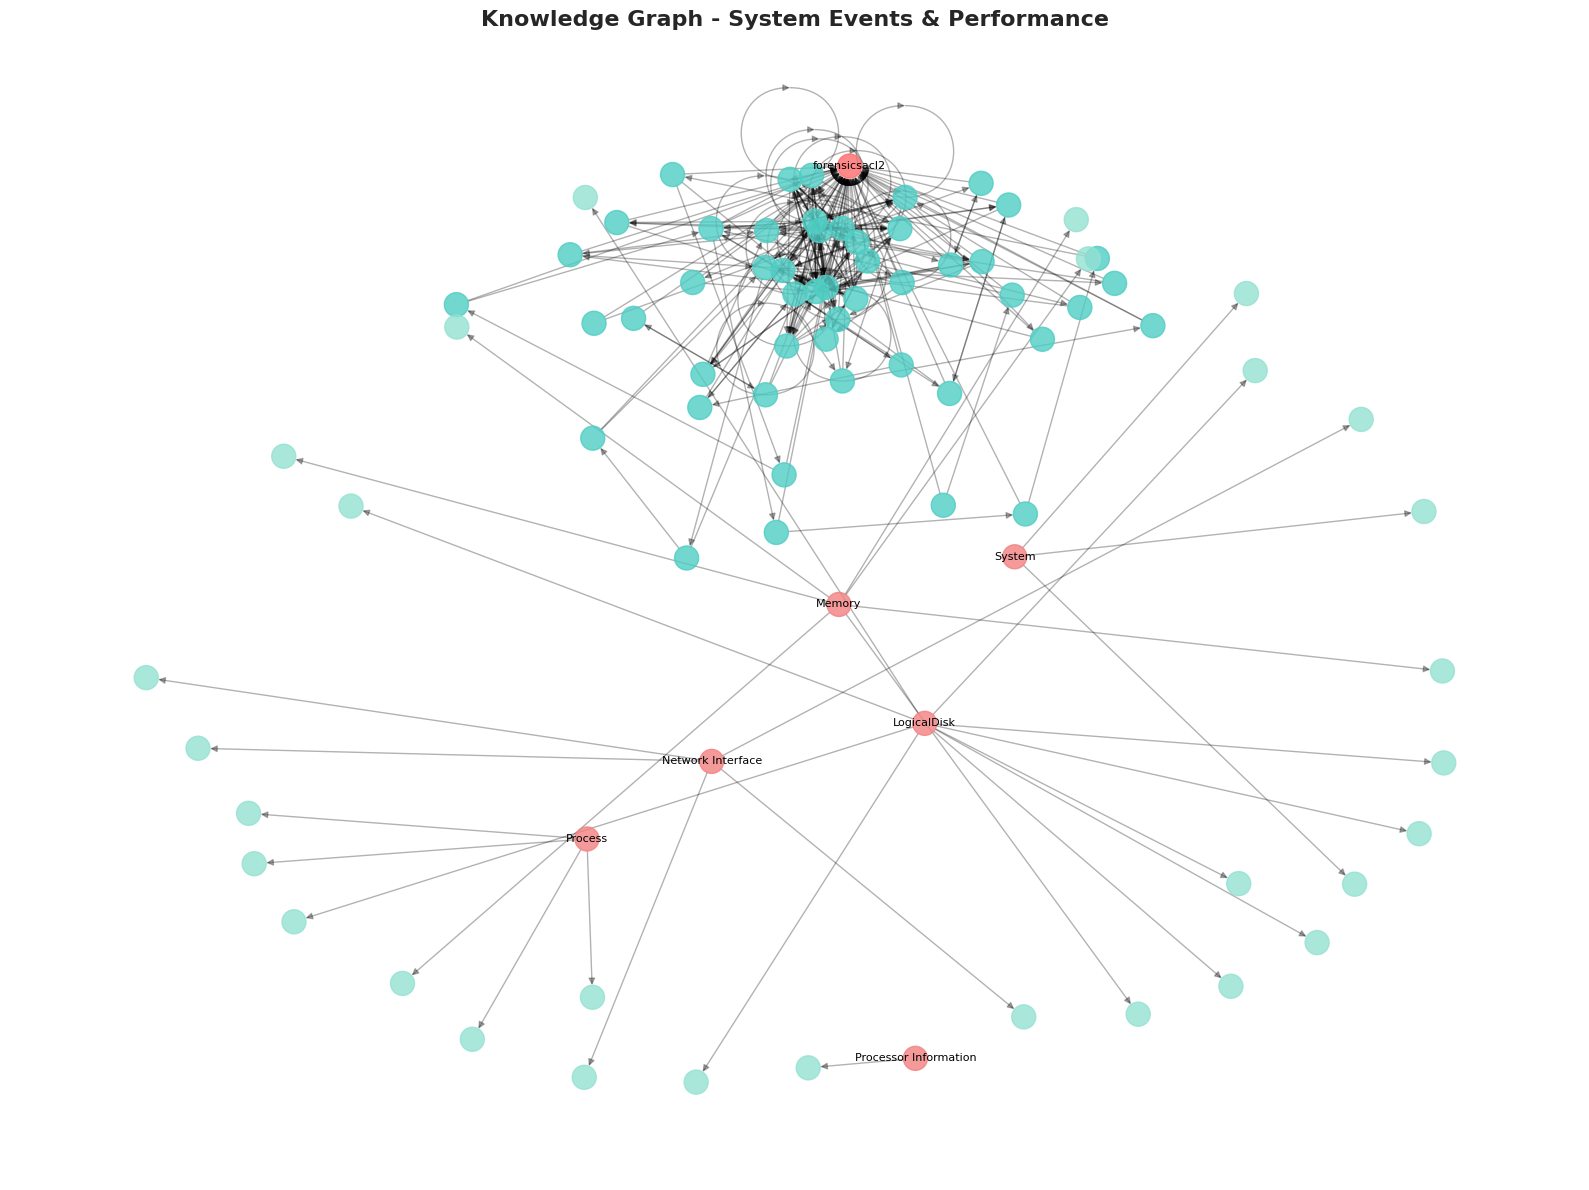

Static graph visualization saved as 'knowledge_graph_static.png'


In [15]:
# Visualize using matplotlib (static view)
plt.figure(figsize=(16, 12))

# Use spring layout for better visualization
pos = nx.spring_layout(KG, k=0.5, iterations=50, seed=42)

# Color nodes by type
node_colors = []
for node in KG.nodes():
    node_type = KG.nodes[node].get('node_type', 'Unknown')
    if node_type == 'System':
        node_colors.append('#FF6B6B')  # Red
    elif node_type == 'Event':
        node_colors.append('#4ECDC4')  # Teal
    elif node_type == 'Metric':
        node_colors.append('#95E1D3')  # Light green
    elif node_type == 'Component':
        node_colors.append('#F38181')  # Pink
    else:
        node_colors.append('#CCCCCC')  # Gray

# Draw nodes
nx.draw_networkx_nodes(KG, pos, node_color=node_colors, node_size=300, alpha=0.8)

# Draw edges
nx.draw_networkx_edges(KG, pos, alpha=0.3, arrows=True, arrowsize=10)

# Draw labels (only for important nodes)
important_nodes = {node: KG.nodes[node].get('label', node)
                   for node in KG.nodes()
                   if KG.nodes[node].get('node_type') in ['System', 'Component']}
nx.draw_networkx_labels(KG, pos, important_nodes, font_size=8)

plt.title('Knowledge Graph - System Events & Performance', fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.savefig('knowledge_graph_static.png', dpi=300, bbox_inches='tight')
plt.show()

print("Static graph visualization saved as 'knowledge_graph_static.png'")

In [16]:
# Create interactive visualization using PyVis
def create_interactive_graph(graph, output_file='knowledge_graph.html'):
    """
    Create an interactive HTML visualization of the knowledge graph.
    """
    net = Network(height='800px', width='100%', bgcolor='#222222', font_color='white', directed=True)
    net.barnes_hut(gravity=-8000, central_gravity=0.3, spring_length=200)

    # Add nodes with colors based on type
    for node in graph.nodes():
        node_data = graph.nodes[node]
        node_type = node_data.get('node_type', 'Unknown')
        label = node_data.get('label', node)

        # Set color based on node type
        color_map = {
            'System': '#FF6B6B',
            'Event': '#4ECDC4',
            'Metric': '#95E1D3',
            'Component': '#F38181',
            'Unknown': '#CCCCCC'
        }

        net.add_node(
            node,
            label=label,
            title=f"Type: {node_type}\nNode: {label}",
            color=color_map.get(node_type, '#CCCCCC')
        )

    # Add edges
    for edge in graph.edges(data=True):
        source, target, data = edge
        relationship = data.get('relationship', 'related')
        weight = data.get('weight', 1)

        net.add_edge(
            source,
            target,
            title=f"{relationship} (weight: {weight})",
            value=weight
        )

    # Save and display
    net.save_graph(output_file)
    print(f"Interactive graph saved as '{output_file}'")
    return net

interactive_graph = create_interactive_graph(KG)
print("\n You can open 'knowledge_graph.html' in your browser to explore the interactive graph.")

Interactive graph saved as 'knowledge_graph.html'

 You can open 'knowledge_graph.html' in your browser to explore the interactive graph.


## 2.5 Save Knowledge Graph

In [17]:
# Save graph to GEXF format (compatible with Gephi and other tools)
nx.write_gexf(KG, 'knowledge_graph.gexf')
print("Knowledge Graph saved as 'knowledge_graph.gexf'")

# Also save as GraphML
nx.write_graphml(KG, 'knowledge_graph.graphml')
print("Knowledge Graph saved as 'knowledge_graph.graphml'")

# Print graph statistics
print("\n Knowledge Graph Statistics:")
print(f"  • Total Nodes: {KG.number_of_nodes()}")
print(f"  • Total Edges: {KG.number_of_edges()}")
print(f"  • Graph Density: {nx.density(KG):.4f}")
print(f"  • Is Directed: {KG.is_directed()}")

Knowledge Graph saved as 'knowledge_graph.gexf'
Knowledge Graph saved as 'knowledge_graph.graphml'

 Knowledge Graph Statistics:
  • Total Nodes: 87
  • Total Edges: 273
  • Graph Density: 0.0365
  • Is Directed: True


---
# PHASE 3: Root Cause & Causal Inference

Analyze the Knowledge Graph to identify root causes using correlation analysis and graph algorithms.

## 3.1 Compute Correlations Between Events and Metrics

In [18]:
# Create time-series data for correlation analysis
def prepare_correlation_data(events_df, perf_df, time_window='5min'):
    """
    Prepare data for correlation analysis by aggregating over time windows.
    """
    # Aggregate events
    events_df['TimeWindow'] = events_df['TimeGenerated'].dt.floor(time_window)
    event_counts = events_df.groupby(['TimeWindow', 'EventID']).size().reset_index(name='EventCount')
    event_pivot = event_counts.pivot(index='TimeWindow', columns='EventID', values='EventCount').fillna(0)
    event_pivot.columns = [f'Event_{col}' for col in event_pivot.columns]

    # Aggregate performance metrics
    perf_df['TimeWindow'] = perf_df['TimeGenerated'].dt.floor(time_window)
    perf_agg = perf_df.pivot_table(
        index='TimeWindow',
        columns='MetricName',
        values='CounterValue',
        aggfunc='mean'
    ).fillna(method='ffill').fillna(0)

    # Merge
    combined = event_pivot.join(perf_agg, how='outer').fillna(0)

    return combined

correlation_data = prepare_correlation_data(events_featured, perf_clean)
print(f"Correlation data prepared with shape: {correlation_data.shape}")

Correlation data prepared with shape: (9, 133)


Computing correlations...
Correlation matrix computed: (87, 46)


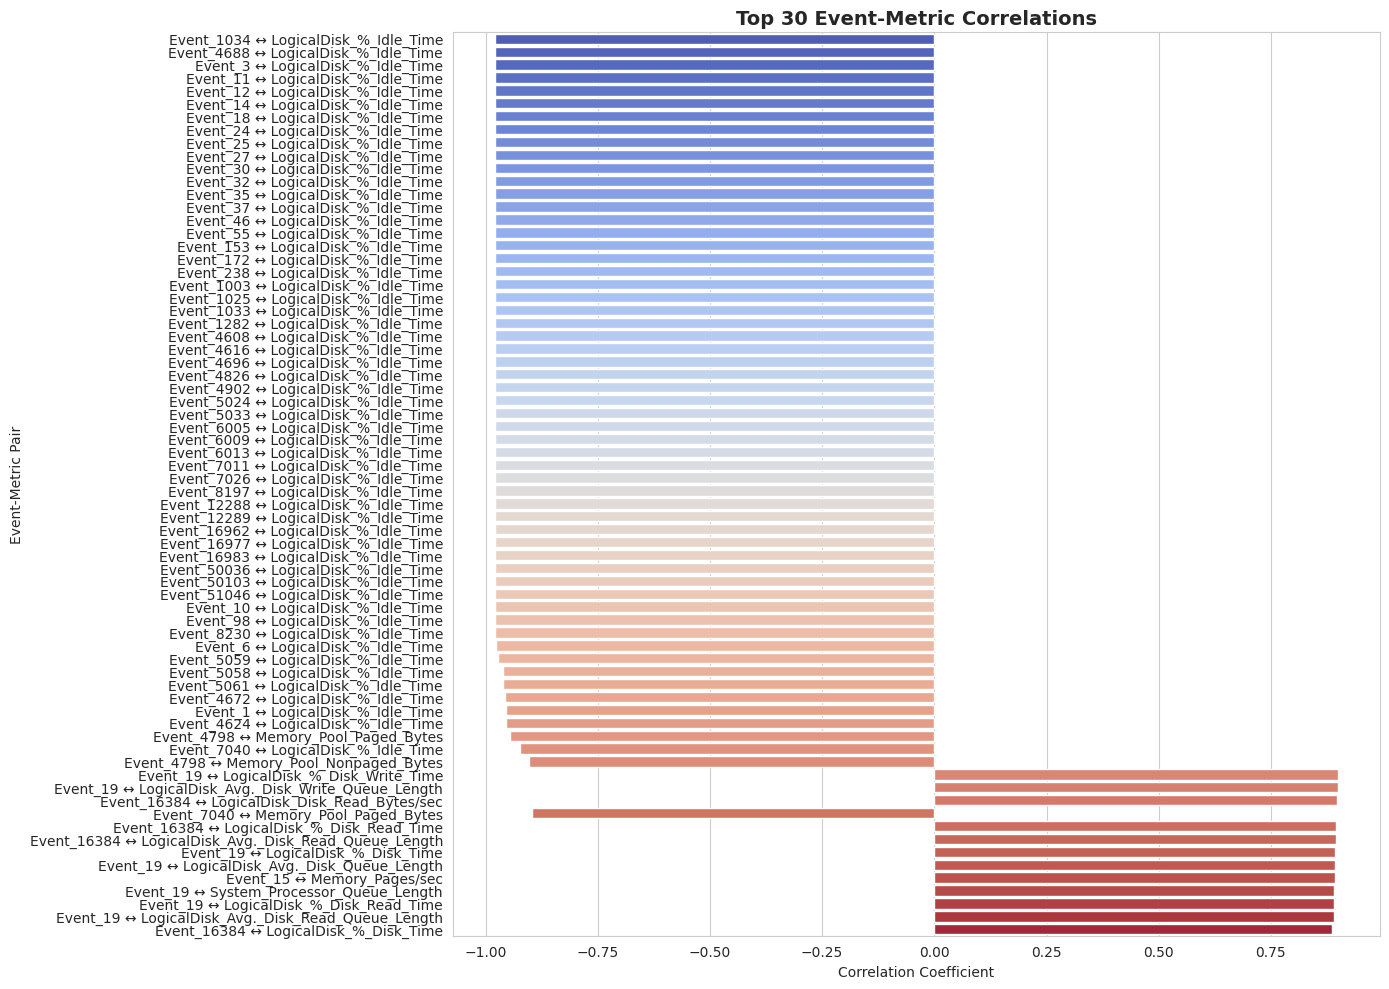

Correlation analysis complete!


In [19]:
# Compute correlation matrix
print("Computing correlations...")
correlation_matrix = correlation_data.corr()

# Extract event-metric correlations
event_cols = [col for col in correlation_matrix.columns if col.startswith('Event_')]
metric_cols = [col for col in correlation_matrix.columns if not col.startswith('Event_')]

# Get cross-correlations (events vs metrics)
cross_corr = correlation_matrix.loc[event_cols, metric_cols]

print(f"Correlation matrix computed: {cross_corr.shape}")

# Visualize top correlations
plt.figure(figsize=(14, 10))
top_corr = cross_corr.abs().stack().nlargest(70)
top_corr_df = pd.DataFrame({
    'Event-Metric Pair': [f"{idx[0]} ↔ {idx[1]}" for idx in top_corr.index],
    'Correlation': [cross_corr.loc[idx] for idx in top_corr.index]
})

sns.barplot(data=top_corr_df, y='Event-Metric Pair', x='Correlation', palette='coolwarm')
plt.title('Top 30 Event-Metric Correlations', fontsize=14, fontweight='bold')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.savefig('top_correlations.png', dpi=300, bbox_inches='tight')
plt.show()

print("Correlation analysis complete!")

In [20]:
# ---- PREP 1: build correlation_data ----
def prepare_correlation_data(events_df, perf_df, time_window='5min'):
    events_df = events_df.copy()
    perf_df = perf_df.copy()

    # Aggregate events
    events_df['TimeWindow'] = events_df['TimeGenerated'].dt.floor(time_window)
    event_counts = (
        events_df.groupby(['TimeWindow', 'EventID'])
                 .size()
                 .reset_index(name='EventCount')
    )
    event_pivot = event_counts.pivot(index='TimeWindow',
                                     columns='EventID',
                                     values='EventCount').fillna(0)
    event_pivot.columns = [f'Event_{col}' for col in event_pivot.columns]

    # Aggregate performance metrics
    perf_df['TimeWindow'] = perf_df['TimeGenerated'].dt.floor(time_window)
    perf_agg = perf_df.pivot_table(
        index='TimeWindow',
        columns='MetricName',
        values='CounterValue',
        aggfunc='mean'
    ).fillna(method='ffill').fillna(0)

    # Merge
    combined = event_pivot.join(perf_agg, how='outer').fillna(0)
    combined.sort_index(inplace=True)
    return combined

correlation_data = prepare_correlation_data(events_featured, perf_clean)

# ---- PREP 2: correlations (events vs metrics) ----
corr = correlation_data.corr()
event_cols  = [c for c in corr.columns if c.startswith('Event_')]
metric_cols = [c for c in corr.columns if not c.startswith('Event_')]

cross_corr = corr.loc[event_cols, metric_cols]

# Long-form pairs
pairs = cross_corr.stack().reset_index()
pairs.columns = ['Event', 'Metric', 'Correlation']
pairs['abs_corr'] = pairs['Correlation'].abs()


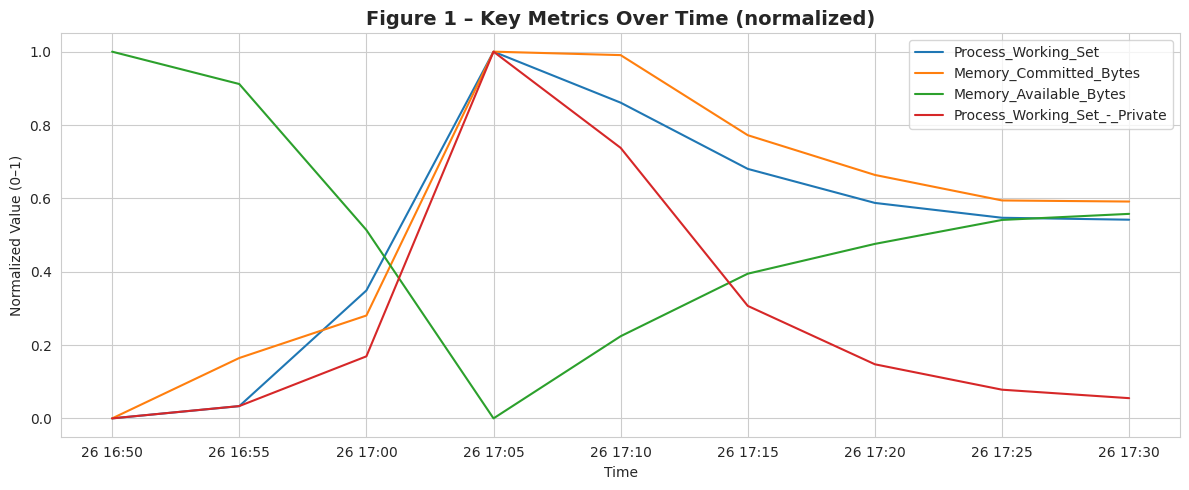

In [21]:
# Pick the top 3–4 most variable metrics
metric_variance = correlation_data[metric_cols].var().sort_values(ascending=False)
top_metrics = metric_variance.head(4).index.tolist()

plt.figure(figsize=(12, 5))
for m in top_metrics:
    series = correlation_data[m]
    series_norm = (series - series.min()) / (series.max() - series.min() + 1e-9)
    plt.plot(series_norm.index, series_norm, label=m)

plt.title("Figure 1 – Key Metrics Over Time (normalized)", fontsize=14, fontweight="bold")
plt.xlabel("Time")
plt.ylabel("Normalized Value (0–1)")
plt.legend()
plt.tight_layout()
plt.show()


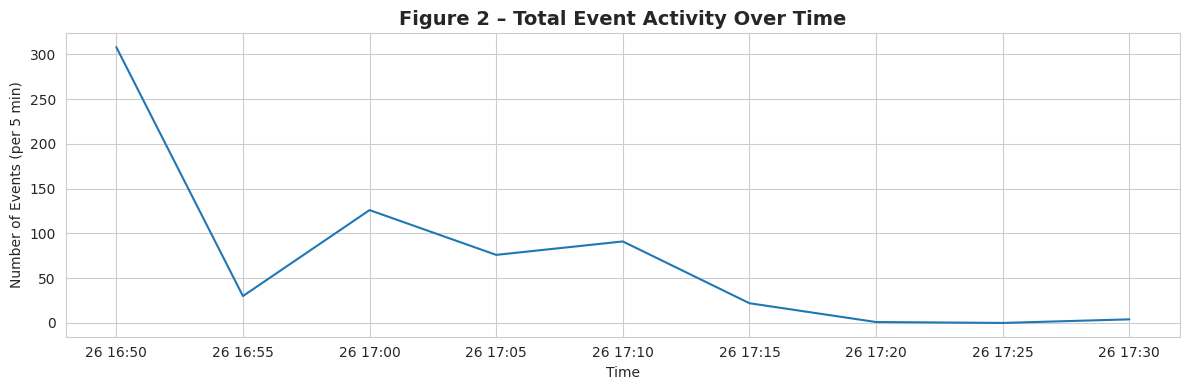

In [22]:
# Total events per time window
event_counts_ts = correlation_data[event_cols].sum(axis=1)

plt.figure(figsize=(12, 4))
plt.plot(event_counts_ts.index, event_counts_ts.values)
plt.title("Figure 2 – Total Event Activity Over Time", fontsize=14, fontweight="bold")
plt.xlabel("Time")
plt.ylabel("Number of Events (per 5 min)")
plt.tight_layout()
plt.show()


In [23]:
# ---- PREP 3: build event bundles based on co-occurrence ----
event_only = correlation_data[event_cols]
event_corr = event_only.corr()

threshold = 0.99   # treat events with corr ≥ 0.99 as a bundle
visited = set()
bundles = []

for ev in event_corr.index:
    if ev in visited:
        continue
    group = event_corr.index[event_corr.loc[ev] >= threshold].tolist()
    visited.update(group)
    bundles.append(group)

# Map each event to a bundle name
bundle_map = {}
for i, group in enumerate(bundles, start=1):
    name = f"EventBundle_{i}"
    for ev in group:
        bundle_map[ev] = name

print("Event bundles:")
for i, g in enumerate(bundles, start=1):
    print(f"  EventBundle_{i}: {g}")

# Build bundle time series (sum counts in each bundle)
bundle_df = pd.DataFrame(index=correlation_data.index)
for ev, name in bundle_map.items():
    if name not in bundle_df:
        bundle_df[name] = 0
    bundle_df[name] += correlation_data[ev]

metric_only = correlation_data[metric_cols]
correlation_data_bundles = pd.concat([bundle_df, metric_only], axis=1)

# correlations with bundles
corr_b = correlation_data_bundles.corr()
bundle_cols = [c for c in corr_b.columns if c.startswith("EventBundle_")]
metric_cols_b = [c for c in corr_b.columns if c not in bundle_cols]

cross_corr_b = corr_b.loc[bundle_cols, metric_cols_b]
pairs_b = cross_corr_b.stack().reset_index()
pairs_b.columns = ['Bundle', 'Metric', 'Correlation']
pairs_b['abs_corr'] = pairs_b['Correlation'].abs()


Event bundles:
  EventBundle_1: ['Event_0']
  EventBundle_2: ['Event_1', 'Event_5058', 'Event_5059', 'Event_5061']
  EventBundle_3: ['Event_3', 'Event_6', 'Event_10', 'Event_11', 'Event_12', 'Event_14', 'Event_18', 'Event_24', 'Event_25', 'Event_27', 'Event_30', 'Event_32', 'Event_35', 'Event_37', 'Event_46', 'Event_55', 'Event_98', 'Event_153', 'Event_172', 'Event_238', 'Event_1003', 'Event_1025', 'Event_1033', 'Event_1034', 'Event_1282', 'Event_4608', 'Event_4616', 'Event_4688', 'Event_4696', 'Event_4826', 'Event_4902', 'Event_5024', 'Event_5033', 'Event_6005', 'Event_6009', 'Event_6013', 'Event_7011', 'Event_7026', 'Event_8197', 'Event_8230', 'Event_12288', 'Event_12289', 'Event_16962', 'Event_16977', 'Event_16983', 'Event_50036', 'Event_50103', 'Event_51046']
  EventBundle_4: ['Event_15']
  EventBundle_5: ['Event_16']
  EventBundle_6: ['Event_19']
  EventBundle_7: ['Event_20']
  EventBundle_8: ['Event_26', 'Event_4634']
  EventBundle_9: ['Event_43']
  EventBundle_10: ['Event_44']
 

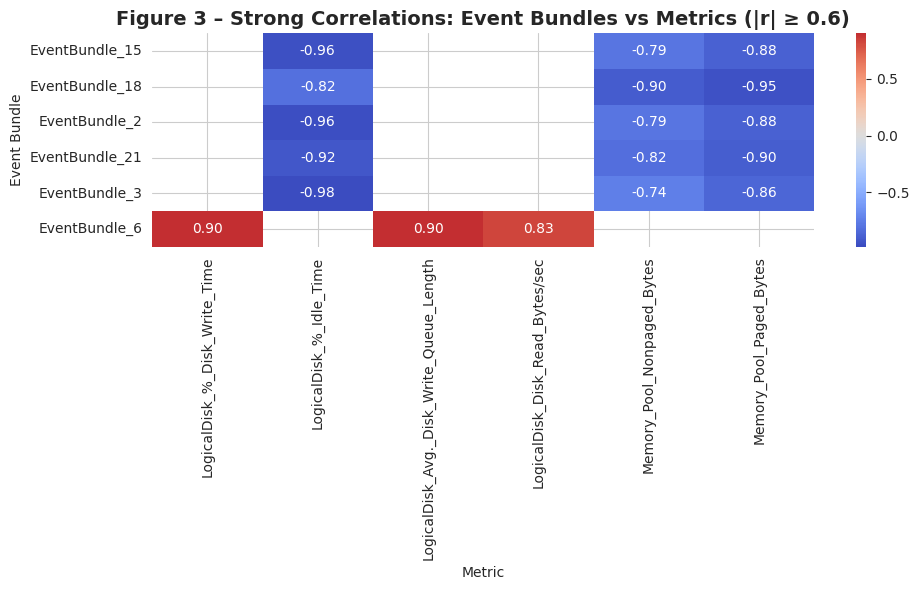

In [24]:
# Strong correlations only
strong_b = pairs_b[pairs_b['abs_corr'] >= 0.6]

top_bundles = (
    strong_b.groupby('Bundle')['abs_corr']
            .max()
            .sort_values(ascending=False)
            .head(6)
            .index
)

top_metrics = (
    strong_b.groupby('Metric')['abs_corr']
            .max()
            .sort_values(ascending=False)
            .head(6)
            .index
)

heat_b = strong_b[strong_b['Bundle'].isin(top_bundles) &
                  strong_b['Metric'].isin(top_metrics)]

heat_pivot_b = heat_b.pivot(index='Bundle', columns='Metric', values='Correlation')

plt.figure(figsize=(10, 6))
sns.heatmap(heat_pivot_b, annot=True, fmt=".2f", center=0, cmap='coolwarm')
plt.title("Figure 3 – Strong Correlations: Event Bundles vs Metrics (|r| ≥ 0.6)",
          fontsize=14, fontweight="bold")
plt.xlabel("Metric")
plt.ylabel("Event Bundle")
plt.tight_layout()
plt.show()


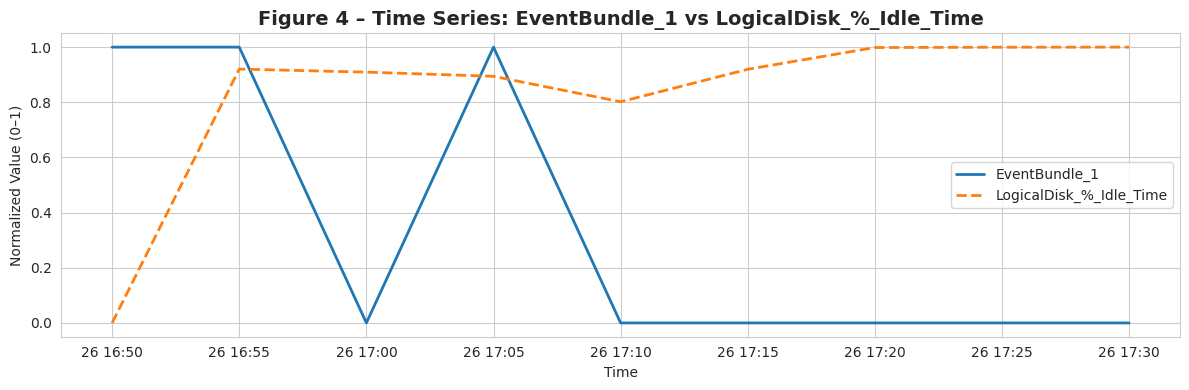

In [25]:
def plot_bundle_metric_timeseries(data_bundles, bundle_col, metric_col):
    ts = data_bundles[[bundle_col, metric_col]].copy().sort_index()

    # Normalize to 0–1 so they share an axis
    ts_norm = (ts - ts.min()) / (ts.max() - ts.min() + 1e-9)

    plt.figure(figsize=(12, 4))
    plt.plot(ts_norm.index, ts_norm[bundle_col], label=bundle_col, linewidth=2)
    plt.plot(ts_norm.index, ts_norm[metric_col], label=metric_col,
             linestyle="--", linewidth=2)
    plt.title(f"Figure 4 – Time Series: {bundle_col} vs {metric_col}",
              fontsize=14, fontweight="bold")
    plt.xlabel("Time")
    plt.ylabel("Normalized Value (0–1)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example (use actual names that appear in Figure 3):
plot_bundle_metric_timeseries(
    correlation_data_bundles,
    bundle_col="EventBundle_1",
    metric_col="LogicalDisk_%_Idle_Time"
)


## 3.2 Add Causal Edges to Knowledge Graph

In [26]:
# Add causal relationships based on high correlations
CORRELATION_THRESHOLD = 0.5  # Threshold for significant correlation

causal_edges_added = 0

for event in event_cols:
    for metric in metric_cols:
        corr_value = cross_corr.loc[event, metric]

        # Add causal edge if correlation is strong
        if abs(corr_value) > CORRELATION_THRESHOLD:
            if KG.has_node(event) and KG.has_node(metric):
                KG.add_edge(
                    event,
                    metric,
                    relationship='CORRELATES_WITH' if corr_value > 0 else 'INVERSELY_CORRELATED',
                    weight=abs(corr_value),
                    correlation=corr_value
                )
                causal_edges_added += 1

print(f"Added {causal_edges_added} causal edges based on correlations")
print(f"Updated graph: {KG.number_of_nodes()} nodes, {KG.number_of_edges()} edges")

Added 555 causal edges based on correlations
Updated graph: 87 nodes, 828 edges


## 3.3 Run Graph Algorithms for Root Cause Detection

In [27]:
# Calculate PageRank to identify most influential nodes
print("Running PageRank algorithm...")
pagerank = nx.pagerank(KG, weight='weight')

# Sort by PageRank score
pagerank_sorted = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)

print("\n Top 20 Most Influential Nodes (PageRank):")
print("=" * 80)
for i, (node, score) in enumerate(pagerank_sorted[:20], 1):
    node_type = KG.nodes[node].get('node_type', 'Unknown')
    label = KG.nodes[node].get('label', node)
    print(f"{i:2d}. {label:40s} | Type: {node_type:10s} | Score: {score:.6f}")

Running PageRank algorithm...

 Top 20 Most Influential Nodes (PageRank):
 1. forensicsacl2                            | Type: System     | Score: 0.122340
 2. LogicalDisk_%_Idle_Time                  | Type: Metric     | Score: 0.024374
 3. Memory_Pool_Paged_Bytes                  | Type: Metric     | Score: 0.022812
 4. Event_4624                               | Type: Event      | Score: 0.021693
 5. Memory_Pool_Nonpaged_Bytes               | Type: Metric     | Score: 0.020706
 6. System_System_Up_Time                    | Type: Metric     | Score: 0.018787
 7. Memory_Cache_Bytes                       | Type: Metric     | Score: 0.018105
 8. Memory_Committed_Bytes                   | Type: Metric     | Score: 0.017828
 9. Memory_%_Committed_Bytes_In_Use          | Type: Metric     | Score: 0.017828
10. Process_Working_Set                      | Type: Metric     | Score: 0.017619
11. Process_Handle_Count                     | Type: Metric     | Score: 0.017531
12. Memory_Available_Byt

In [28]:
# Calculate Degree Centrality
print("\n Calculating Degree Centrality...")
in_degree = dict(KG.in_degree())
out_degree = dict(KG.out_degree())

# Sort by in-degree (nodes that are affected by many others)
in_degree_sorted = sorted(in_degree.items(), key=lambda x: x[1], reverse=True)

print("\n Top 15 Nodes by In-Degree (Most Affected):")
print("=" * 80)
for i, (node, degree) in enumerate(in_degree_sorted[:15], 1):
    node_type = KG.nodes[node].get('node_type', 'Unknown')
    label = KG.nodes[node].get('label', node)
    print(f"{i:2d}. {label:40s} | Type: {node_type:10s} | In-Degree: {degree}")

# Sort by out-degree (nodes that affect many others - potential root causes)
out_degree_sorted = sorted(out_degree.items(), key=lambda x: x[1], reverse=True)

print("\n Top 15 Nodes by Out-Degree (Potential Root Causes):")
print("=" * 80)
for i, (node, degree) in enumerate(out_degree_sorted[:15], 1):
    node_type = KG.nodes[node].get('node_type', 'Unknown')
    label = KG.nodes[node].get('label', node)
    print(f"{i:2d}. {label:40s} | Type: {node_type:10s} | Out-Degree: {degree}")


 Calculating Degree Centrality...

 Top 15 Nodes by In-Degree (Most Affected):
 1. forensicsacl2                            | Type: System     | In-Degree: 50
 2. System_System_Up_Time                    | Type: Metric     | In-Degree: 43
 3. Memory_Cache_Bytes                       | Type: Metric     | In-Degree: 43
 4. Memory_Pool_Paged_Bytes                  | Type: Metric     | In-Degree: 42
 5. Memory_Pool_Nonpaged_Bytes               | Type: Metric     | In-Degree: 41
 6. LogicalDisk_Free_Megabytes               | Type: Metric     | In-Degree: 40
 7. LogicalDisk_%_Free_Space                 | Type: Metric     | In-Degree: 40
 8. LogicalDisk_%_Idle_Time                  | Type: Metric     | In-Degree: 40
 9. Memory_Committed_Bytes                   | Type: Metric     | In-Degree: 38
10. Memory_%_Committed_Bytes_In_Use          | Type: Metric     | In-Degree: 38
11. Process_Handle_Count                     | Type: Metric     | In-Degree: 37
12. Process_Working_Set                 

In [29]:
# Calculate Betweenness Centrality (nodes that connect different parts of the graph)
print("\n Calculating Betweenness Centrality...")
betweenness = nx.betweenness_centrality(KG, weight='weight')
betweenness_sorted = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)

print("\n Top 15 Nodes by Betweenness Centrality (Critical Bridges):")
print("=" * 80)
for i, (node, score) in enumerate(betweenness_sorted[:15], 1):
    node_type = KG.nodes[node].get('node_type', 'Unknown')
    label = KG.nodes[node].get('label', node)
    print(f"{i:2d}. {label:40s} | Type: {node_type:10s} | Score: {score:.6f}")


 Calculating Betweenness Centrality...

 Top 15 Nodes by Betweenness Centrality (Critical Bridges):
 1. Event_16                                 | Type: Event      | Score: 0.139130
 2. Event_4624                               | Type: Event      | Score: 0.116752
 3. Event_20                                 | Type: Event      | Score: 0.073794
 4. Event_4672                               | Type: Event      | Score: 0.059011
 5. Event_4688                               | Type: Event      | Score: 0.054693
 6. Event_15                                 | Type: Event      | Score: 0.044310
 7. Event_4799                               | Type: Event      | Score: 0.042166
 8. Event_5379                               | Type: Event      | Score: 0.040755
 9. Event_18                                 | Type: Event      | Score: 0.035568
10. Event_16384                              | Type: Event      | Score: 0.035011
11. Event_43                                 | Type: Event      | Score: 0.0347

## 3.4 Identify Top Root Causes

In [30]:
# Combine multiple metrics to identify root causes
def identify_root_causes(graph, pagerank, out_degree, betweenness, top_n=10):
    """
    Combine multiple centrality metrics to identify likely root causes.
    Focuses on Event nodes with high out-degree and PageRank.
    """
    # Normalize scores
    max_pr = max(pagerank.values())
    max_od = max(out_degree.values())
    max_bc = max(betweenness.values()) if max(betweenness.values()) > 0 else 1

    root_cause_scores = {}

    for node in graph.nodes():
        node_type = graph.nodes[node].get('node_type', 'Unknown')

        # Focus on Event nodes as potential root causes
        if node_type == 'Event':
            # Composite score: weighted combination of metrics
            pr_score = pagerank.get(node, 0) / max_pr
            od_score = out_degree.get(node, 0) / max_od
            bc_score = betweenness.get(node, 0) / max_bc

            # Weighted combination (out-degree is most important for root causes)
            composite_score = (0.4 * od_score) + (0.3 * pr_score) + (0.3 * bc_score)

            root_cause_scores[node] = {
                'composite_score': composite_score,
                'pagerank': pr_score,
                'out_degree': out_degree.get(node, 0),
                'betweenness': bc_score,
                'label': graph.nodes[node].get('label', node),
                'description': graph.nodes[node].get('description', 'N/A')
            }

    # Sort by composite score
    sorted_causes = sorted(root_cause_scores.items(), key=lambda x: x[1]['composite_score'], reverse=True)

    return sorted_causes[:top_n]

top_root_causes = identify_root_causes(KG, pagerank, out_degree, betweenness, top_n=10)

print("\n" + "=" * 100)
print("TOP 10 LIKELY ROOT CAUSES")
print("=" * 100)

for i, (node, metrics) in enumerate(top_root_causes, 1):
    print(f"\n{i}. {metrics['label']}")
    print(f"   Description: {metrics['description']}")
    print(f"   Composite Score: {metrics['composite_score']:.4f}")
    print(f"   Out-Degree: {metrics['out_degree']} (affects {metrics['out_degree']} other entities)")
    print(f"   PageRank: {metrics['pagerank']:.4f}")
    print(f"   Betweenness: {metrics['betweenness']:.4f}")
    print(f"   -" * 50)


TOP 10 LIKELY ROOT CAUSES

1. Event_16
   Description: The iommu fault reporting has been initialized.
   Composite Score: 0.7064
   Out-Degree: 31 (affects 31 other entities)
   PageRank: 0.1389
   Betweenness: 1.0000
   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -

2. Event_4672
   Description: Special privileges assigned to new logon.  Subject: 	Security ID:		S-1-5-18 	Account Name:		SYSTEM 	...
   Composite Score: 0.5652
   Out-Degree: 34 (affects 34 other entities)
   PageRank: 0.1265
   Betweenness: 0.4241
   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -

3. Event_4624
   Description: An account was successfully logged on.  Subject: 	Security ID:		S-1-0-0 	Account Name:		- 	Accou

## 3.5 Trace Impact Paths

In [31]:
# Trace paths from root causes to impacted metrics
def trace_impact_paths(graph, root_cause, target_type='Metric', max_depth=3):
    """
    Find all paths from a root cause to nodes of a specific type.
    """
    target_nodes = [n for n in graph.nodes() if graph.nodes[n].get('node_type') == target_type]

    paths = []
    for target in target_nodes:
        try:
            # Find shortest path
            path = nx.shortest_path(graph, source=root_cause, target=target)
            if len(path) <= max_depth + 1:
                paths.append(path)
        except nx.NetworkXNoPath:
            continue

    return paths

# Trace paths for top root cause
if top_root_causes:
    top_cause_node = top_root_causes[0][0]
    top_cause_label = top_root_causes[0][1]['label']

    impact_paths = trace_impact_paths(KG, top_cause_node, target_type='Metric', max_depth=3)

    print(f"\n Impact Paths from '{top_cause_label}':")
    print("=" * 80)

    for i, path in enumerate(impact_paths[:10], 1):  # Show first 10 paths
        path_str = " → ".join([KG.nodes[n].get('label', n) for n in path])
        print(f"{i}. {path_str}")

    if len(impact_paths) > 10:
        print(f"\n... and {len(impact_paths) - 10} more paths")


 Impact Paths from 'Event_16':
1. Event_16 → Event_19 → Process_Thread_Count
2. Event_16 → System_System_Up_Time
3. Event_16 → Memory_Cache_Bytes
4. Event_16 → Event_6 → Process_Handle_Count
5. Event_16 → Event_6 → Memory_Committed_Bytes
6. Event_16 → Event_6 → System_Processes
7. Event_16 → Event_6 → Memory_%_Committed_Bytes_In_Use
8. Event_16 → Event_6 → Memory_Available_Bytes
9. Event_16 → Memory_Pool_Paged_Bytes
10. Event_16 → System_Processor_Queue_Length

... and 17 more paths


---
# PHASE 4: LLM Integration for Querying

Integrate a free, lightweight LLM for natural language querying of the knowledge graph.

## 4.1 Load Free LLM Model

In [32]:
# Load a lightweight text generation model from Hugging Face
# Using Google's FLAN-T5 - a free, instruction-following model
print("Loading FLAN-T5 model (this may take a few minutes)...")

model_name = "google/flan-t5-base"  # Lightweight model that runs on Colab

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# Create pipeline for easier use
llm_pipeline = pipeline(
    "text2text-generation",
    model=model,
    tokenizer=tokenizer,
    max_length=512,
    do_sample=False
)

print("LLM loaded successfully!")
print(f"Model: {model_name}")
print(f"Parameters: ~{sum(p.numel() for p in model.parameters()) / 1e6:.1f}M")

Loading FLAN-T5 model (this may take a few minutes)...


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Device set to use cuda:0


LLM loaded successfully!
Model: google/flan-t5-base
Parameters: ~247.6M


## 4.2 Convert Graph to Natural Language Triples

In [33]:
# Extract knowledge triples from the graph
def extract_knowledge_triples(graph, max_triples=500):
    """
    Convert graph relationships into natural language triples.
    Format: (Subject, Relationship, Object)
    """
    triples = []

    for source, target, data in graph.edges(data=True):
        source_label = graph.nodes[source].get('label', source)
        target_label = graph.nodes[target].get('label', target)
        relationship = data.get('relationship', 'related to')

        # Create natural language triple
        triple = f"{source_label} {relationship.lower().replace('_', ' ')} {target_label}"
        triples.append({
            'subject': source_label,
            'relationship': relationship,
            'object': target_label,
            'text': triple,
            'weight': data.get('weight', 1)
        })

        if len(triples) >= max_triples:
            break

    return triples

knowledge_triples = extract_knowledge_triples(KG, max_triples=500)

print(f"Extracted {len(knowledge_triples)} knowledge triples")
print("\nSample triples:")
for triple in knowledge_triples[:10]:
    print(f"  • {triple['text']}")

Extracted 500 knowledge triples

Sample triples:
  • Event_5379 occurs in forensicsacl2
  • Event_5379 precedes Event_5379
  • Event_5379 precedes Event_4799
  • Event_5379 precedes Event_4624
  • Event_5379 precedes Event_44
  • Event_5379 precedes Event_8230
  • Event_5379 precedes Event_7040
  • Event_5379 precedes Event_16
  • Event_5379 precedes Event_6
  • Event_5379 precedes Event_19


## 4.3 Build Query Functions

In [34]:
# Function to query the knowledge graph
def query_knowledge_graph(query, graph, triples, top_k=5):
    """
    Query the knowledge graph and return relevant information.
    Uses simple keyword matching for retrieval.
    """
    query_lower = query.lower()

    # Find relevant triples using keyword matching
    relevant_triples = []
    for triple in triples:
        # Check if any query words are in the triple
        triple_text = triple['text'].lower()
        if any(word in triple_text for word in query_lower.split()):
            relevant_triples.append(triple)

    # Sort by weight and take top_k
    relevant_triples.sort(key=lambda x: x['weight'], reverse=True)
    top_triples = relevant_triples[:top_k]

    return top_triples

# Function to generate natural language answer using LLM
def generate_answer_google(query, relevant_triples, llm):
    """
    Generate a natural language answer using the LLM.
    """
    # Construct context from triples
    context = "Knowledge: \n"
    for triple in relevant_triples:
        context += f"- {triple['text']}\n"

    # Construct prompt
    prompt = f"{context}\nQuestion: {query}\nAnswer:"

    # Generate answer
    result = llm(prompt, max_length=200, do_sample=False)
    answer = result[0]['generated_text']

    return answer

# Main query function
def query_graph_llm_google(query_text, graph=KG, triples=knowledge_triples, llm=llm_pipeline):
    """
    Complete query pipeline: retrieve relevant info and generate answer.
    """
    print(f"\n Query: {query_text}")
    print("=" * 80)

    # Retrieve relevant triples
    relevant = query_knowledge_graph(query_text, graph, triples, top_k=10)

    if not relevant:
        print(" No relevant information found in the knowledge graph.")
        return None

    print(f"\n Found {len(relevant)} relevant facts:")
    for i, triple in enumerate(relevant[:5], 1):
        print(f"  {i}. {triple['text']}")

    # Generate answer using LLM
    print("\n Generating answer...")
    answer = generate_answer_google(query_text, relevant, llm)

    print("\n Answer:")
    print(answer)
    print("=" * 80)

    return answer

print("Query functions ready!")

Query functions ready!


## 4.4 Generate Root Cause Report

In [35]:
# Function to generate a comprehensive root cause report
def generate_root_cause_report(top_causes, graph, llm=llm_pipeline):
    """
    Generate a human-readable root cause analysis report.
    """
    report = []
    report.append("=" * 100)
    report.append("ROOT CAUSE ANALYSIS REPORT")
    report.append("=" * 100)
    report.append("\n")

    report.append("## Executive Summary\n")
    report.append(f"Based on analysis of {graph.number_of_nodes()} entities and {graph.number_of_edges()} relationships, ")
    report.append(f"we have identified {len(top_causes)} primary root causes affecting system performance.\n\n")

    report.append("## Top Root Causes\n")

    for i, (node, metrics) in enumerate(top_causes[:5], 1):
        report.append(f"\n### {i}. {metrics['label']}\n")
        report.append(f"**Description:** {metrics['description']}\n\n")
        report.append(f"**Impact Score:** {metrics['composite_score']:.4f}\n")
        report.append(f"**Affects:** {metrics['out_degree']} downstream entities\n\n")

        # Get connected nodes
        connected = list(graph.neighbors(node))[:5]
        if connected:
            report.append("**Directly Impacts:**\n")
            for conn in connected:
                conn_label = graph.nodes[conn].get('label', conn)
                conn_type = graph.nodes[conn].get('node_type', 'Unknown')
                report.append(f"  - {conn_label} ({conn_type})\n")
        report.append("\n")

    report.append("\n## Recommendations\n\n")
    report.append("1. **Monitor high-priority events:** Focus on events with high out-degree centrality.\n")
    report.append("2. **Implement early warning systems:** Set up alerts for root cause events.\n")
    report.append("3. **Review system architecture:** Consider isolating components with high impact.\n")
    report.append("4. **Conduct deeper analysis:** Investigate temporal patterns in root cause events.\n")

    report.append("\n" + "=" * 100)

    full_report = "".join(report)
    return full_report

# Generate and display the report
root_cause_report = generate_root_cause_report(top_root_causes, KG)
print(root_cause_report)

# Save report to file
with open('root_cause_report.txt', 'w') as f:
    f.write(root_cause_report)

print("\n Report saved as 'root_cause_report.txt'")

====================================================================================================ROOT CAUSE ANALYSIS REPORT====================================================================================================
## Executive Summary
Based on analysis of 87 entities and 828 relationships, we have identified 10 primary root causes affecting system performance.

## Top Root Causes

### 1. Event_16
**Description:** The iommu fault reporting has been initialized.

**Impact Score:** 0.7064
**Affects:** 31 downstream entities

**Directly Impacts:**
  - forensicsacl2 (System)
  - Event_6 (Event)
  - Event_11 (Event)
  - Event_4688 (Event)
  - Event_4624 (Event)


### 2. Event_4672
**Description:** Special privileges assigned to new logon.  Subject: 	Security ID:		S-1-5-18 	Account Name:		SYSTEM 	...

**Impact Score:** 0.5652
**Affects:** 34 downstream entities

**Directly Impacts:**
  - forensicsacl2 (System)
  - Event_4624 (Event)
  - Event_16 (Event)
  - Event_4648 (Event)
  -

## 4.5 Example Queries

In [36]:
# Example 1: Query about specific event
query_graph_llm_google("How many events precedes with another event?")


 Query: How many events precedes with another event?

 Found 10 relevant facts:
  1. Event_5379 precedes Event_5379
  2. Event_4624 precedes Event_4672
  3. Event_4672 precedes Event_4624
  4. Event_1034 precedes Event_1034
  5. Event_4799 precedes Event_4799

 Generating answer...

 Answer:
3


'3'

In [37]:
# Example 2: Query about performance metrics
query_graph_llm_google("What metrics are affected by events?")


 Query: What metrics are affected by events?

 Found 10 relevant facts:
  1. Event_4798 inversely correlated Memory_Pool_Paged_Bytes
  2. Event_4798 inversely correlated Memory_Pool_Nonpaged_Bytes
  3. Event_16384 correlates with LogicalDisk_Disk_Read_Bytes/sec
  4. Event_7040 inversely correlated Memory_Pool_Paged_Bytes
  5. Event_1 inversely correlated Memory_Pool_Paged_Bytes

 Generating answer...

 Answer:
LogicalDisk_Disk_Read_Bytes/sec


'LogicalDisk_Disk_Read_Bytes/sec'

In [38]:
# Example 3: Query about root causes
query_graph_llm_google("What are the main root causes of system issues?")


 Query: What are the main root causes of system issues?

 Found 10 relevant facts:
  1. Event_19 correlates with System_Processor_Queue_Length
  2. Event_7040 inversely correlated System_System_Up_Time
  3. Event_44 correlates with System_Processor_Queue_Length
  4. Event_4798 inversely correlated System_System_Up_Time
  5. Event_44 inversely correlated System_System_Up_Time

 Generating answer...

 Answer:
Event_19 inversely correlated System_Processor_Queue_Length Event_4798 inversely correlated System_Processor_Queue_Length Event_4798 inversely correlated System_Processor_Queue_Length Event_4798 inversely correlated System_Processor_Queue_Length Event_4798 inversely correlated System_Processor_Queue_Length Event_4798 inversely correlated System_Processor_Queue_Length Event_4798 inversely correlated System_Processor_Queue_Length Event_4798 inversely correlated System_Processor_Queue_Length Event_4798 inversely correlated System_Processor_Qu


'Event_19 inversely correlated System_Processor_Queue_Length Event_4798 inversely correlated System_Processor_Queue_Length Event_4798 inversely correlated System_Processor_Queue_Length Event_4798 inversely correlated System_Processor_Queue_Length Event_4798 inversely correlated System_Processor_Queue_Length Event_4798 inversely correlated System_Processor_Queue_Length Event_4798 inversely correlated System_Processor_Queue_Length Event_4798 inversely correlated System_Processor_Queue_Length Event_4798 inversely correlated System_Processor_Qu'

In [65]:
query_graph_llm_google("For system forensicsacl2, what are the likely root cause events?")


 Query: For system forensicsacl2, what are the likely root cause events?

 Found 10 relevant facts:
  1. Event_5379 occurs in forensicsacl2
  2. Event_4624 occurs in forensicsacl2
  3. Event_4672 occurs in forensicsacl2
  4. Event_16 occurs in forensicsacl2
  5. Event_4799 occurs in forensicsacl2

 Generating answer...

 Answer:
Event_5379 occurs in forensicsacl2


'Event_5379 occurs in forensicsacl2'

In [58]:
query_graph_llm_google("What are the most critical root cause events I should fix first?")


 Query: What are the most critical root cause events I should fix first?

 Found 10 relevant facts:
  1. Event_5379 occurs in forensicsacl2
  2. Event_4624 occurs in forensicsacl2
  3. Event_4672 occurs in forensicsacl2
  4. Event_16 occurs in forensicsacl2
  5. Event_4799 occurs in forensicsacl2

 Generating answer...

 Answer:
Event_4799 occurs in forensicsacl2


'Event_4799 occurs in forensicsacl2'

In [66]:
query_graph_llm_google("What caused high CPU on Top 2 events")


 Query: What caused high CPU on Top 2 events

 Found 10 relevant facts:
  1. Event_5379 occurs in forensicsacl2
  2. Event_4624 occurs in forensicsacl2
  3. Event_4672 occurs in forensicsacl2
  4. Event_4624 precedes Event_4672
  5. Event_16 occurs in forensicsacl2

 Generating answer...

 Answer:
Event_4799 occurs in forensicsacl2


'Event_4799 occurs in forensicsacl2'

---
# 📊 FINAL SUMMARY & VISUALIZATIONS

Comprehensive summary of the entire analysis.

In [41]:
# Create comprehensive summary dashboard
print("\n" + "="*100)
print("ANALYSIS COMPLETE - SUMMARY")
print("="*100)

print("\n Phase 1: Data Preprocessing")
print(f"  ✓ Loaded {len(events_df)} events and {len(perf_df)} performance records")
print(f"  ✓ Cleaned data: {len(events_clean)} events, {len(perf_clean)} metrics")
print(f"  ✓ Created {len(unified_data)} unified time-series records")

print("\n Phase 2: Knowledge Graph")
print(f"  ✓ Built graph with {KG.number_of_nodes()} nodes and {KG.number_of_edges()} edges")
print(f"  ✓ Entity types: System, Component, Event, Metric")
print(f"  ✓ Relationship types: OCCURS_IN, AFFECTS, CORRELATES_WITH, PRECEDES")

print("\n Phase 3: Root Cause Analysis")
print(f"  ✓ Computed {cross_corr.size} event-metric correlations")
print(f"  ✓ Added {causal_edges_added} causal relationships")
print(f"  ✓ Identified {len(top_root_causes)} primary root causes")

print("\n Phase 4: LLM Integration")
print(f"  ✓ Loaded {model_name} model")
print(f"  ✓ Extracted {len(knowledge_triples)} knowledge triples")
print(f"  ✓ Natural language query system ready")

print("\n Generated Files:")
print("  • events_cleaned.csv")
print("  • perf_cleaned.csv")
print("  • unified_data.csv")
print("  • knowledge_graph.gexf")
print("  • knowledge_graph.graphml")
print("  • knowledge_graph.html (interactive)")
print("  • knowledge_graph_static.png")
print("  • top_correlations.png")
print("  • root_cause_report.txt")

print("\n Analysis complete! All deliverables generated.")
print("="*100)


ANALYSIS COMPLETE - SUMMARY

 Phase 1: Data Preprocessing
  ✓ Loaded 733 events and 1692 performance records
  ✓ Cleaned data: 658 events, 1692 metrics
  ✓ Created 43 unified time-series records

 Phase 2: Knowledge Graph
  ✓ Built graph with 87 nodes and 828 edges
  ✓ Entity types: System, Component, Event, Metric
  ✓ Relationship types: OCCURS_IN, AFFECTS, CORRELATES_WITH, PRECEDES

 Phase 3: Root Cause Analysis
  ✓ Computed 4002 event-metric correlations
  ✓ Added 555 causal relationships
  ✓ Identified 10 primary root causes

 Phase 4: LLM Integration
  ✓ Loaded google/flan-t5-base model
  ✓ Extracted 500 knowledge triples
  ✓ Natural language query system ready

 Generated Files:
  • events_cleaned.csv
  • perf_cleaned.csv
  • unified_data.csv
  • knowledge_graph.gexf
  • knowledge_graph.graphml
  • knowledge_graph.html (interactive)
  • knowledge_graph_static.png
  • top_correlations.png
  • root_cause_report.txt

 Analysis complete! All deliverables generated.


# GPT 5 MINI IMPLEMENTATION

## Implementation

In [42]:
!pip install -q openai

In [ ]:
import os
os.environ["OPENAI_API_KEY"] = "INSERT YOUR KEY"


In [44]:

# -------------------------------------------------
# 2. Imports and OpenAI client setup
#        import os
#        os.environ["OPENAI_API_KEY"] = "sk_...."
# -------------------------------------------------
from openai import OpenAI                # New style OpenAI client
from typing import List, Dict, Any       # For type hints in our functions

# Create a single shared client instance
client = OpenAI()  # Reads OPENAI_API_KEY from environment

print("Using OpenAI model: gpt-5-mini")
print("OpenAI client ready. Make sure OPENAI_API_KEY is set in the environment.")

# -------------------------------------------------
# 3. Extract knowledge triples from the graph
#    - Assumes you already have:
#        KG  -> a NetworkX graph object
#        top_root_causes -> list of (node_id, metrics_dict)
# -------------------------------------------------
def extract_knowledge_triples(graph, max_triples: int = 500) -> List[Dict[str, Any]]:
    """
    Convert graph relationships into simple natural language triples.

    Each triple is a dictionary with:
      - subject
      - relationship
      - object
      - text   (natural language form)
      - weight (edge weight if present, else 1)
    """
    # Initialize an empty list to store all triples
    triples: List[Dict[str, Any]] = []

    # Iterate over all edges of the graph, including edge data
    for source, target, data in graph.edges(data=True):
        # Get a human readable label for the source node
        # If there is no label, fall back to the node id
        source_label = graph.nodes[source].get("label", source)

        # Same idea for the target node
        target_label = graph.nodes[target].get("label", target)

        # Determine the relationship type for this edge
        # If missing, default to a generic phrase
        relationship = data.get("relationship", "related to")

        # Build a natural language sentence for this triple
        # Example: "CPU spike causes High latency"
        triple_text = f"{source_label} {relationship.lower().replace('_', ' ')} {target_label}"

        # Append the structured triple record
        triples.append(
            {
                "subject": source_label,
                "relationship": relationship,
                "object": target_label,
                "text": triple_text,
                "weight": data.get("weight", 1),
            }
        )

        # If we hit the maximum triple count, stop
        if len(triples) >= max_triples:
            break

    # Return the full list of triples
    return triples

# Extract triples from your knowledge graph KG
knowledge_triples = extract_knowledge_triples(KG, max_triples=500)

# Quick sanity check printout
print(f"Extracted {len(knowledge_triples)} knowledge triples\n")
print("Sample triples:")
for triple in knowledge_triples[:10]:
    print(f"  • {triple['text']}")

# -------------------------------------------------
# 4. Simple keyword based triple retrieval
# -------------------------------------------------
def query_knowledge_graph(
    query: str,
    graph,
    triples: List[Dict[str, Any]],
    top_k: int = 5,
) -> List[Dict[str, Any]]:
    """
    Retrieve relevant triples for a natural language query.

    Retrieval steps:
      - Lowercase the query.
      - Split the query into individual words.
      - Keep any triple whose text contains at least one of these words.
      - Sort the matched triples by weight in descending order.
      - Return only the top_k triples.
    """
    # Lowercase the query once for reuse
    query_lower = query.lower()

    # Prepare a list to collect matching triples
    relevant_triples: List[Dict[str, Any]] = []

    # Loop through all triples
    for triple in triples:
        # Lowercase the triple text for case insensitive match
        triple_text = triple["text"].lower()

        # If any query word appears inside the triple text, mark as relevant
        if any(word in triple_text for word in query_lower.split()):
            relevant_triples.append(triple)

    # Sort relevant triples by edge weight, highest first
    relevant_triples.sort(key=lambda x: x["weight"], reverse=True)

    # Return only the top_k most relevant triples
    return relevant_triples[:top_k]

# -------------------------------------------------
# 5. Use OpenAI gpt-5-mini to generate answers
# -------------------------------------------------
def generate_answer_openai(
    query: str,
    relevant_triples: List[Dict[str, Any]],
    model_name: str = "gpt-5-mini",
) -> str:
    """
    Generate a natural language answer using OpenAI gpt-5-mini.

    Steps:
      - Turn relevant triples into a compact "Knowledge" context.
      - Build a prompt that tells the model how to use that context.
      - Call the chat completions endpoint.
      - Return the model answer text.
    """
    # Build a bullet list of facts from the triples
    context_lines: List[str] = []
    for triple in relevant_triples:
        context_lines.append(f"- {triple['text']}")

    # Combine all bullet points into a knowledge block
    context_block = "Knowledge:\n" + "\n".join(context_lines)

    # Build the full user prompt string
    prompt = (
        "You are a root cause analysis assistant.\n"
        "Use only the facts in the Knowledge section below.\n"
        "Explain clearly and stay focused on the question.\n\n"
        f"{context_block}\n\n"
        f"Question: {query}\n"
        "Answer:"
    )

    # Call the OpenAI chat completion API
    completion = client.chat.completions.create(
        model=model_name,
        messages=[
            {
                "role": "user",
                "content": prompt,
            }
        ],
    )

    # Extract the answer text from the first choice
    answer_text: str = completion.choices[0].message.content

    return answer_text

# -------------------------------------------------
# 6. Full query pipeline that prints everything nicely
# -------------------------------------------------
def query_graph_llm(
    query_text: str,
    graph=KG,
    triples: List[Dict[str, Any]] = knowledge_triples,
    model_name: str = "gpt-5-mini",
) -> str:
    """
    End to end query function.

    It will:
      - print hello at starting
      - Print the query.
      - Retrieve relevant triples.
      - Print the retrieved facts.
      - Call OpenAI gpt-5-mini to generate an answer.
      - Print and return the final answer.
    """
    # Show the incoming query
    print(f"\n Query: {query_text}")
    print("=" * 80)

    # Retrieve relevant triples using the basic keyword matcher
    relevant = query_knowledge_graph(query_text, graph, triples, top_k=10)

    # If no triples match, report and exit early
    if not relevant:
        print("No relevant information found in the knowledge graph.")
        return ""

    # Print how many relevant facts we got and show the first few
    print(f"\n Found {len(relevant)} relevant facts:")
    for i, triple in enumerate(relevant[:5], 1):
        print(f"  {i}. {triple['text']}")

    # Ask the OpenAI model for an answer
    print("\n Generating answer with OpenAI gpt-5-mini...")
    answer = generate_answer_openai(query_text, relevant, model_name=model_name)

    # Print the answer in a clear block
    print("\n Answer:")
    print(answer)
    print("=" * 80)

    # Return the answer string so you can reuse it if needed
    return answer

print("Query functions wired to OpenAI gpt-5-mini.")


Using OpenAI model: gpt-5-mini
OpenAI client ready. Make sure OPENAI_API_KEY is set in the environment.
Extracted 500 knowledge triples

Sample triples:
  • Event_5379 occurs in forensicsacl2
  • Event_5379 precedes Event_5379
  • Event_5379 precedes Event_4799
  • Event_5379 precedes Event_4624
  • Event_5379 precedes Event_44
  • Event_5379 precedes Event_8230
  • Event_5379 precedes Event_7040
  • Event_5379 precedes Event_16
  • Event_5379 precedes Event_6
  • Event_5379 precedes Event_19
Query functions wired to OpenAI gpt-5-mini.


In [45]:

# -------------------------------------------------
# 7. Root cause report generator
#    - Reuses your top_root_causes and KG.
# -------------------------------------------------
def generate_root_cause_report(
    top_causes: List[Any],
    graph,
) -> str:
    """
    Generate a human readable root cause analysis report.

    Expects:
      - top_causes: list of (node_id, metrics_dict)
        where metrics_dict has keys:
          - label
          - description
          - composite_score
          - out_degree
      - graph: NetworkX graph with node attributes.
    """
    # Start with an empty list for report lines
    report_lines: List[str] = []

    # Header section
    report_lines.append("=" * 100 + "\n")
    report_lines.append("ROOT CAUSE ANALYSIS REPORT\n")
    report_lines.append("=" * 100 + "\n\n")

    # Executive summary
    report_lines.append("## Executive Summary\n\n")
    report_lines.append(
        f"Based on analysis of {graph.number_of_nodes()} entities and "
        f"{graph.number_of_edges()} relationships, "
        f"we have identified {len(top_causes)} primary root causes affecting system performance.\n\n"
    )

    # Top causes section
    report_lines.append("## Top Root Causes\n")

    # Loop over the first five most important causes
    for i, (node, metrics) in enumerate(top_causes[:5], 1):
        report_lines.append(f"\n### {i}. {metrics['label']}\n\n")
        report_lines.append(f"**Description:** {metrics['description']}\n\n")
        report_lines.append(f"**Impact Score:** {metrics['composite_score']:.4f}\n\n")
        report_lines.append(f"**Affects:** {metrics['out_degree']} downstream entities\n\n")

        # Show a few directly connected nodes to highlight impact area
        connected_nodes = list(graph.neighbors(node))[:5]
        if connected_nodes:
            report_lines.append("**Directly Impacts:**\n")
            for conn in connected_nodes:
                conn_label = graph.nodes[conn].get("label", conn)
                conn_type = graph.nodes[conn].get("node_type", "Unknown")
                report_lines.append(f"  - {conn_label} ({conn_type})\n")
        report_lines.append("\n")

    # Recommendation section
    report_lines.append("\n## Recommendations\n\n")
    report_lines.append("1. **Monitor high priority events:** Focus on events with high out degree centrality.\n")
    report_lines.append("2. **Implement early warning systems:** Set up alerts for critical root cause events.\n")
    report_lines.append("3. **Review system architecture:** Consider isolating components with very high impact.\n")
    report_lines.append("4. **Conduct deeper analysis:** Investigate temporal patterns of recurring root cause events.\n")

    # Footer line
    report_lines.append("\n" + "=" * 100 + "\n")

    # Combine everything into a single string
    full_report = "".join(report_lines)

    return full_report

# -------------------------------------------------
# 8. Build and save the root cause report
# -------------------------------------------------
root_cause_report = generate_root_cause_report(top_root_causes, KG)

# Print the report to the notebook
print(root_cause_report)

# Save it as a text file inside the Colab environment
with open("root_cause_report.txt", "w") as f:
    f.write(root_cause_report)

print("\n Report saved as 'root_cause_report.txt'")

# -------------------------------------------------
# 9. Example query using the full pipeline
# -------------------------------------------------


ROOT CAUSE ANALYSIS REPORT

## Executive Summary

Based on analysis of 87 entities and 828 relationships, we have identified 10 primary root causes affecting system performance.

## Top Root Causes

### 1. Event_16

**Description:** The iommu fault reporting has been initialized.

**Impact Score:** 0.7064

**Affects:** 31 downstream entities

**Directly Impacts:**
  - forensicsacl2 (System)
  - Event_6 (Event)
  - Event_11 (Event)
  - Event_4688 (Event)
  - Event_4624 (Event)


### 2. Event_4672

**Description:** Special privileges assigned to new logon.  Subject: 	Security ID:		S-1-5-18 	Account Name:		SYSTEM 	...

**Impact Score:** 0.5652

**Affects:** 34 downstream entities

**Directly Impacts:**
  - forensicsacl2 (System)
  - Event_4624 (Event)
  - Event_16 (Event)
  - Event_4648 (Event)
  - Event_24 (Event)


### 3. Event_4624

**Description:** An account was successfully logged on.  Subject: 	Security ID:		S-1-0-0 	Account Name:		- 	Account D...

**Impact Score:** 0.5520

**Affec

In [46]:
# Example 1: Query about specific event
query_graph_llm("How many events precedes with another event?")


 Query: How many events precedes with another event?

 Found 10 relevant facts:
  1. Event_5379 precedes Event_5379
  2. Event_4624 precedes Event_4672
  3. Event_4672 precedes Event_4624
  4. Event_1034 precedes Event_1034
  5. Event_4799 precedes Event_4799

 Generating answer with OpenAI gpt-5-mini...

 Answer:
7

The events that precede another event (appear on the left side in the given facts) are:
- Event_5379
- Event_4624
- Event_4672
- Event_1034
- Event_4799
- Event_16
- Event_5058


'7\n\nThe events that precede another event (appear on the left side in the given facts) are:\n- Event_5379\n- Event_4624\n- Event_4672\n- Event_1034\n- Event_4799\n- Event_16\n- Event_5058'

In [47]:
# Example 2: Query about performance metrics
query_graph_llm("What metrics are affected by events?")


 Query: What metrics are affected by events?

 Found 10 relevant facts:
  1. Event_4798 inversely correlated Memory_Pool_Paged_Bytes
  2. Event_4798 inversely correlated Memory_Pool_Nonpaged_Bytes
  3. Event_16384 correlates with LogicalDisk_Disk_Read_Bytes/sec
  4. Event_7040 inversely correlated Memory_Pool_Paged_Bytes
  5. Event_1 inversely correlated Memory_Pool_Paged_Bytes

 Generating answer with OpenAI gpt-5-mini...

 Answer:
Metrics affected by events (based only on the provided facts):

- Memory_Pool_Paged_Bytes — inversely correlated with: Event_4798, Event_7040, Event_1, Event_5061, Event_5058, Event_4624, Event_4672, Event_5059
- Memory_Pool_Nonpaged_Bytes — inversely correlated with: Event_4798
- LogicalDisk_Disk_Read_Bytes/sec — correlated with: Event_16384


'Metrics affected by events (based only on the provided facts):\n\n- Memory_Pool_Paged_Bytes — inversely correlated with: Event_4798, Event_7040, Event_1, Event_5061, Event_5058, Event_4624, Event_4672, Event_5059\n- Memory_Pool_Nonpaged_Bytes — inversely correlated with: Event_4798\n- LogicalDisk_Disk_Read_Bytes/sec — correlated with: Event_16384'

In [48]:
# Example 3: Query about root causes
query_graph_llm("What are the main root causes of system issues?")


 Query: What are the main root causes of system issues?

 Found 10 relevant facts:
  1. Event_19 correlates with System_Processor_Queue_Length
  2. Event_7040 inversely correlated System_System_Up_Time
  3. Event_44 correlates with System_Processor_Queue_Length
  4. Event_4798 inversely correlated System_System_Up_Time
  5. Event_44 inversely correlated System_System_Up_Time

 Generating answer with OpenAI gpt-5-mini...

 Answer:
Based only on the provided facts, the system issues trace to two main kinds of root causes:

1. Events associated with increased processor queue length (CPU backlog)
   - Event_19
   - Event_44
   - Event_43

2. Events associated with reduced system up time (more frequent or longer downtime)
   - Event_7040
   - Event_4798
   - Event_44
   - Event_16
   - Event_0
   - Event_5379
   - Event_4672

Note: Event_44 appears in both groups, making it a particularly significant contributor to overall system problems.


'Based only on the provided facts, the system issues trace to two main kinds of root causes:\n\n1. Events associated with increased processor queue length (CPU backlog)\n   - Event_19\n   - Event_44\n   - Event_43\n\n2. Events associated with reduced system up time (more frequent or longer downtime)\n   - Event_7040\n   - Event_4798\n   - Event_44\n   - Event_16\n   - Event_0\n   - Event_5379\n   - Event_4672\n\nNote: Event_44 appears in both groups, making it a particularly significant contributor to overall system problems.'

In [49]:
# Example 4: Custom query
custom_query = "Which components have the most performance problems?"
query_graph_llm(custom_query)


 Query: Which components have the most performance problems?
No relevant information found in the knowledge graph.


''

In [51]:
# Example 6: Query about performance metrics
query_graph_llm("What caused high CPU on Top 2 events")


 Query: What caused high CPU on Top 2 events

 Found 10 relevant facts:
  1. Event_5379 occurs in forensicsacl2
  2. Event_4624 occurs in forensicsacl2
  3. Event_4672 occurs in forensicsacl2
  4. Event_4624 precedes Event_4672
  5. Event_16 occurs in forensicsacl2

 Generating answer with OpenAI gpt-5-mini...

 Answer:
Cause: a cyclical dependency between Event_4624 and Event_4672.

Facts used:
- Event_4624 and Event_4672 both occur in forensicsacl2.
- Event_4624 precedes Event_4672.
- Event_4672 precedes Event_4624.

Because each precedes the other, a loop/cycle exists between those two events; that cycle is the cause of the high CPU on the top two events.


'Cause: a cyclical dependency between Event_4624 and Event_4672.\n\nFacts used:\n- Event_4624 and Event_4672 both occur in forensicsacl2.\n- Event_4624 precedes Event_4672.\n- Event_4672 precedes Event_4624.\n\nBecause each precedes the other, a loop/cycle exists between those two events; that cycle is the cause of the high CPU on the top two events.'

In [52]:
# Example 7: Query about performance metrics
query_graph_llm("Which events caused high Memory_Pool_Nonpaged_Bytes ?")


 Query: Which events caused high Memory_Pool_Nonpaged_Bytes ?

 Found 10 relevant facts:
  1. Event_4798 inversely correlated Memory_Pool_Nonpaged_Bytes
  2. Event_7040 inversely correlated Memory_Pool_Nonpaged_Bytes
  3. Event_1 inversely correlated Memory_Pool_Nonpaged_Bytes
  4. Event_4624 inversely correlated Memory_Pool_Nonpaged_Bytes
  5. Event_5061 inversely correlated Memory_Pool_Nonpaged_Bytes

 Generating answer with OpenAI gpt-5-mini...

 Answer:
None. All listed events are inversely correlated with Memory_Pool_Nonpaged_Bytes, i.e., they are associated with decreased (not increased) Memory_Pool_Nonpaged_Bytes. The events are:
- Event_4798
- Event_7040
- Event_1
- Event_4624
- Event_5061
- Event_5058
- Event_4672
- Event_5059
- Event_6
- Event_11


'None. All listed events are inversely correlated with Memory_Pool_Nonpaged_Bytes, i.e., they are associated with decreased (not increased) Memory_Pool_Nonpaged_Bytes. The events are:\n- Event_4798\n- Event_7040\n- Event_1\n- Event_4624\n- Event_5061\n- Event_5058\n- Event_4672\n- Event_5059\n- Event_6\n- Event_11'

In [53]:
# Example 7: Query about performance metrics
query_graph_llm("For system forensicsacl2, what are the likely root cause events?")


 Query: For system forensicsacl2, what are the likely root cause events?

 Found 10 relevant facts:
  1. Event_5379 occurs in forensicsacl2
  2. Event_4624 occurs in forensicsacl2
  3. Event_4672 occurs in forensicsacl2
  4. Event_16 occurs in forensicsacl2
  5. Event_4799 occurs in forensicsacl2

 Generating answer with OpenAI gpt-5-mini...

 Answer:
Based only on the provided facts, the likely root cause events for system forensicsacl2 are:

- Event_5379
- Event_4624
- Event_4672
- Event_16
- Event_4799
- Event_15
- Event_1034
- Event_44
- Event_43
- Event_4798


'Based only on the provided facts, the likely root cause events for system forensicsacl2 are:\n\n- Event_5379\n- Event_4624\n- Event_4672\n- Event_16\n- Event_4799\n- Event_15\n- Event_1034\n- Event_44\n- Event_43\n- Event_4798'

In [55]:
query_graph_llm("What are the most critical root cause events I should fix first?")


 Query: What are the most critical root cause events I should fix first?

 Found 10 relevant facts:
  1. Event_5379 occurs in forensicsacl2
  2. Event_4624 occurs in forensicsacl2
  3. Event_4672 occurs in forensicsacl2
  4. Event_16 occurs in forensicsacl2
  5. Event_4799 occurs in forensicsacl2

 Generating answer with OpenAI gpt-5-mini...

 Answer:
From the Knowledge provided the only facts are that the following events occur in forensicsacl2:
- Event_5379
- Event_4624
- Event_4672
- Event_16
- Event_4799
- Event_15
- Event_1034
- Event_44
- Event_43
- Event_4798

With only those facts, I cannot determine which are the most critical to fix first — there is no information about severity, frequency, impact, timestamps, affected assets, or relationships between events. Any prioritization would require additional context.

Recommended next steps to identify the most critical root-cause events:
1. Collect context for each listed event: counts, timestamps, source/destination systems, use

'From the Knowledge provided the only facts are that the following events occur in forensicsacl2:\n- Event_5379\n- Event_4624\n- Event_4672\n- Event_16\n- Event_4799\n- Event_15\n- Event_1034\n- Event_44\n- Event_43\n- Event_4798\n\nWith only those facts, I cannot determine which are the most critical to fix first — there is no information about severity, frequency, impact, timestamps, affected assets, or relationships between events. Any prioritization would require additional context.\n\nRecommended next steps to identify the most critical root-cause events:\n1. Collect context for each listed event: counts, timestamps, source/destination systems, user accounts, and any correlated alerts.\n2. Determine impact: which events affect production systems, sensitive data, or availability.\n3. Identify root-cause relationships: which events are upstream causes vs. downstream symptoms.\n4. Prioritize remediation by combining severity, scope, and likelihood (e.g., highest-impact or most freque

# Llama Implementation

In [64]:
# @title 🦙 TinyLlama Integration (Failsafe Version)
# Install libraries (if not already present)
!pip install -q accelerate transformers

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

# --- 1. MODEL LOADING ---
# TinyLlama-1.1B-Chat: Robust, fast, and no special permissions needed.
model_id = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

print(f"Loading {model_id}...")

try:
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        device_map="auto",
        torch_dtype=torch.float16  # Standard half-precision for GPU
    )

    # Initialize pipeline
    llama_pipeline = pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        max_new_tokens=512,
        temperature=0.1,
        do_sample=True,
        top_p=0.95
    )
    print("TinyLlama model loaded successfully!")

except Exception as e:
    print(f"Error loading model: {e}")

# --- 2. QUERY FUNCTION ---
def generate_answer_tinyllama(query, relevant_triples, llm):
    # Format context facts
    context_str = "\n".join([f"- {t['text']}" for t in relevant_triples])

    # Manual Prompt Formatting for TinyLlama
    # (This ensures it works even if the tokenizer template is missing)
    prompt = (
        f"<|system|>\n"
        f"You are a Senior Site Reliability Engineer. Answer the question based strictly on the provided Facts. "
        f"If the answer is not in the facts, say you don't know.</s>\n"
        f"<|user|>\n"
        f"Facts:\n{context_str}\n\n"
        f"Question: {query}</s>\n"
        f"<|assistant|>\n"
    )

    # Generate
    outputs = llm(prompt)
    generated_text = outputs[0]["generated_text"]

    # Extract response (everything after the assistant tag)
    if "<|assistant|>" in generated_text:
        response = generated_text.split("<|assistant|>\n")[-1].strip()
    else:
        response = generated_text

    return response

def query_graph_with_llm(query_text, graph=KG, triples=knowledge_triples):
    print(f"\n🤖 Query: {query_text}")
    print("=" * 80)

    # 1. Search Knowledge Graph
    try:
        relevant = query_knowledge_graph(query_text, graph, triples, top_k=15)
    except NameError:
        print("Error: 'query_knowledge_graph' or 'KG' not defined. Run previous cells first.")
        return

    if not relevant:
        print("No relevant information found.")
        return

    print(f"Found {len(relevant)} relevant facts.")

    # 2. Generate Answer
    try:
        answer = generate_answer_tinyllama(query_text, relevant, llama_pipeline)
        print(f"\nAnswer:\n{answer}")
    except NameError:
        print("Model pipeline not initialized.")

    print("=" * 80)

# --- 3. TEST ---
query_graph_with_llm("What are the most critical root cause events I should fix first?")

Loading TinyLlama/TinyLlama-1.1B-Chat-v1.0...


Device set to use cuda:0


TinyLlama model loaded successfully!

🤖 Query: What are the most critical root cause events I should fix first?
Found 15 relevant facts.

Answer:
The provided Facts list the most critical root cause events for fixing the issues in the provided forensicsacl2. The most critical root cause events are:

- Event_5379 occurs in forensicsacl2
- Event_4624 occurs in forensicsacl2
- Event_4672 occurs in forensicsacl2
- Event_16 occurs in forensicsacl2
- Event_4799 occurs in forensicsacl2
- Event_15 occurs in forensicsacl2
- Event_1034 occurs in forensicsacl2
- Event_44 occurs in forensicsacl2
- Event_43 occurs in forensicsacl2
- Event_4798 occurs in forensicsacl2
- Event_4688 occurs in forensicsacl2
- Event_6 occurs in forensicsacl2
- Event_5061 occurs in forensicsacl2
- Event_5058 occurs in forensicsacl2
- Event_19 occurs in forensicsacl2

Therefore, it is recommended to fix these critical root cause events first to ensure the most effective and efficient forensic investigation.


In [59]:
query_graph_with_llm("How many events precedes with another event?")


🤖 Query: How many events precedes with another event?
Found 15 relevant facts.

Answer:
The provided facts indicate that there are 6 events that precede with another event:

- Event_5379 precedes Event_4624
- Event_4624 precedes Event_4672
- Event_4672 precedes Event_4624
- Event_1034 precedes Event_1034
- Event_4799 precedes Event_4799
- Event_16 precedes Event_16

Therefore, the answer to the question is 6.


In [61]:
query_graph_with_llm("What metrics are affected by events?")


🤖 Query: What metrics are affected by events?
Found 15 relevant facts.

Answer:
The provided facts indicate that the following metrics are affected by events:

- Event_4798 inversely correlated Memory_Pool_Paged_Bytes
- Event_4798 inversely correlated Memory_Pool_Nonpaged_Bytes
- Event_16384 correlates with LogicalDisk_Disk_Read_Bytes/sec
- Event_7040 inversely correlated Memory_Pool_Paged_Bytes
- Event_1 inversely correlated Memory_Pool_Paged_Bytes
- Event_5061 inversely correlated Memory_Pool_Paged_Bytes
- Event_5058 inversely correlated Memory_Pool_Paged_Bytes
- Event_4624 inversely correlated Memory_Pool_Paged_Bytes
- Event_4672 inversely correlated Memory_Pool_Paged_Bytes
- Event_5059 inversely correlated Memory_Pool_Paged_Bytes
- Event_6 inversely correlated Memory_Pool_Paged_Bytes
- Event_43 correlates with LogicalDisk_Disk_Bytes/sec
- Event_16394 correlates with LogicalDisk_Disk_Bytes/sec
- Event_16394 correlates with LogicalDisk_Disk_Read_Bytes/sec
- Event_44 inversely correl

In [62]:
query_graph_with_llm("What are the main root causes of system issues?")


🤖 Query: What are the main root causes of system issues?
Found 15 relevant facts.

Answer:
The main root causes of system issues are:

1. Event_19 correlates with System_Processor_Queue_Length
2. Event_7040 inversely correlated System_System_Up_Time
3. Event_44 correlates with System_Processor_Queue_Length
4. Event_4798 inversely correlated System_System_Up_Time
5. Event_44 inversely correlated System_Processor_Queue_Length
6. Event_43 correlates with System_Processor_Queue_Length
7. Event_16 inversely correlated System_System_Up_Time
8. Event_0 inversely correlated System_System_Up_Time
9. Event_5379 inversely correlated System_System_Up_Time
10. Event_4672 inversely correlated System_System_Up_Time
11. Event_4624 inversely correlated System_System_Up_Time
12. Event_16 correlates with System_Processor_Queue_Length
13. Event_16384 correlates with System_Processor_Queue_Length
14. Event_1 inversely correlated System_System_Up_Time
15. Event_5061 inversely correlated System_System_Up_Ti

In [63]:
query_graph_with_llm("For system forensicsacl2, what are the likely root cause events?")


🤖 Query: For system forensicsacl2, what are the likely root cause events?
Found 15 relevant facts.

Answer:
Based on the provided facts, the likely root cause events for system forensicsacl2 are:

- Event_5379 occurs in forensicsacl2
- Event_4624 occurs in forensicsacl2
- Event_4672 occurs in forensicsacl2
- Event_16 occurs in forensicsacl2
- Event_4799 occurs in forensicsacl2
- Event_15 occurs in forensicsacl2
- Event_1034 occurs in forensicsacl2
- Event_44 occurs in forensicsacl2
- Event_43 occurs in forensicsacl2
- Event_4798 occurs in forensicsacl2
- Event_4688 occurs in forensicsacl2
- Event_6 occurs in forensicsacl2
- Event_5061 occurs in forensicsacl2
- Event_5058 occurs in forensicsacl2
- Event_19 occurs in forensicsacl2

Note that these events are listed in the order they occur in the provided facts.


In [67]:
query_graph_with_llm("What caused high CPU on Top 2 events")


🤖 Query: What caused high CPU on Top 2 events
Found 15 relevant facts.

Answer:
Answer: The high CPU on Top 2 events is caused by Event_4624 occurring in forensicsacl2, which precedes Event_4672 in forensicsacl2.
